#Arbitrated Dynamic Ensemble

##Get Data

In [1]:
#install libraries
!pip install --upgrade linear-tree

In [2]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from joblib import Parallel, delayed, dump, load
import xgboost as xgb
import time
import yfinance as yf
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from lineartree import LinearBoostRegressor, LinearBoostClassifier
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge


#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
drive.mount('/content/gdrive')

#import time series
datasets = {}
for name in ['sp500', 'eur_usd']:
    datasets[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/{name}_data.csv', index_col=0)
    datasets[name] = datasets[name]
    datasets[name].index.name = 'Date'
    datasets[name].index = pd.to_datetime(datasets[name].index)


Close_price = {}
Log_return = {}
test_residuals = {}
val_residuals = {}
SARIMA_fitted_values = {}
SARIMA_test_predictions = {}
residuals = {}

for name , dataset in datasets.items():

    #save Close price and Log Returns into a pd.Series
    Close_price[name] = dataset['Close'].copy().astype(float)
    # Log_return[name] = dataset['Log Return'].copy().astype(float)

    #drop columns not needed
    # dataset.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)
    dataset.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)


    #import SARIMA residuals
    residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv', index_col=0, sep=",")
    residuals[name].index = pd.to_datetime(residuals[name].index)


    #val residuals
    val_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_val_residuals.csv', index_col=0, sep=",")
    val_residuals[name].index = pd.to_datetime(val_residuals[name].index)

    #test residuals
    test_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_residuals.csv', index_col=0, sep=",")
    test_residuals[name].index = pd.to_datetime(test_residuals[name].index)

    #import SARIMA fitted values (predictions on the training set)
    SARIMA_fitted_values[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv', index_col=0)
    SARIMA_fitted_values[name].index = pd.to_datetime(SARIMA_fitted_values[name].index)

    #import SARIMA predictions on the test set
    SARIMA_test_predictions[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
    SARIMA_test_predictions[name].index = pd.to_datetime(SARIMA_test_predictions[name].index)

Mounted at /content/gdrive


###Helper functions to move data to the GPU

In [4]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

###Get pre-trained models

LSTM followed by CNN

In [5]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    LSTM_CNN_model[name] = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_CNN_model[name].to(device) #move the istance to the device

CNN + LSTM parallel architecture

In [6]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
parallelCNNLSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    parallelCNNLSTM_model[name] = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    parallelCNNLSTM_model[name].to(device) #move the istance to the device

LSTM

In [7]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 3

    LSTM_model[name] = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_model[name].to(device) #move the istance to the device

CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    CNN_model[name] = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    CNN_model[name].to(device) #move the istance to the device

Load models


In [9]:
# from inspect import modulesbyfile
drive.mount("/content/gdrive")

Linear_booster_model = {}
#import trained models
model_names = ["Linear_booster.joblib", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]
model_istances = ["Linear_booster_model", CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]


for name, _ in datasets.items():
    for i, model in enumerate(model_names):
        if model == "Linear_booster.joblib":
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/{name}/{model}'
            Linear_booster_model[name] = load(model_path)
        else:
            #load state dict
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/{name}/{model}_fine_tuned'
            model_istances[i][name].load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##ADE library

In [10]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed, dump, load
import xgboost as xgb
import time
import yfinance as yf
import torch.nn.functional as F
from concurrent.futures import ThreadPoolExecutor
import threading

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator)  # Renamed variable to avoid conflict
    return smape_value

#deep learning meta model architecture
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x


#deep learning meta model architecture
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out


class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl : DataLoader, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in iter(self.dl): #iter will reset the iterator every time the __iter__ mathod gets called
      yield ADE.to_device(batch, device)

  def __len__(self):
    return len(self.dl)



class ADE ():
    def __init__(self, trained_models: list, meta_model, train_data: pd.DataFrame, test_data: pd.DataFrame, window_size : int = 10, error_window = 10, k=3, temperature=1):
        self.trained_models = trained_models
        self.meta_model = self.get_meta_model(meta_model) #accept a string as an input
        self.train_data = pd.DataFrame(train_data)
        self.test_data = pd.DataFrame(test_data)
        self.MinMaxscaler = MinMaxScaler(feature_range=(-1, 1))
        self.Robustscaler = RobustScaler()
        # self.error_scaler = MinMaxScaler(feature_range=(-1, 1))
        self.window_size = window_size
        self.error_window = error_window
        self.k = k
        self.temperature = temperature
        self.test_predictions = []
        self.test_error_predictions = []
        self.device = self.get_device()
        self.lock = threading.Lock()
        self.ensemble_preds = None


        #if there are deep learning models
        if any(isinstance(model, torch.nn.Module) for model in trained_models):
            self.train_loader, self.test_loader = self.data_preprocessing_deep_learning(self.train_data, self.test_data, self.MinMaxscaler, self.window_size)

        #if there are machine learning models
        if any(not isinstance(model, torch.nn.Module) for model in trained_models):
            self.X_train, self.y_train, self.X_test, self.y_test = self.data_preprocessing_machine_learning(self.train_data, self.test_data, self.Robustscaler, self.window_size)


    def feature_engineer(self, dataset, residual_prediction):
        #predicted residuals
        print("residual prediction shape")
        print(residual_prediction.shape)
        dataset['predicted residuals'] = residual_prediction.reshape(-1,)

        #lagged features
        dataset['error_lag1'] = dataset['error'].shift(1)
        dataset['error_lag2'] = dataset['error'].shift(2)
        dataset['error_lag3'] = dataset['error'].shift(3)

        #rolling features
        dataset['error_rolling_mean_7'] = dataset['error'].rolling(window=7, min_periods=1).mean()
        dataset['error_rolling_std_7'] = dataset['error'].rolling(window=7, min_periods=1).std()

        #first difference of error (error momentum)
        dataset['error_diff1'] = dataset['error'] - dataset['error_lag1']

        #second difference of error (error acceleration)
        dataset['error_diff2'] = dataset['error_diff1'] - dataset['error_diff1'].shift(1)

        #Z-score normalization of error using the 7-period rolling statistics
        dataset['error_zscore_7'] = (dataset['error'] - dataset['error_rolling_mean_7']) / dataset['error_rolling_std_7']

        #exponential weighted moving average (EWMA) of error
        dataset['error_ewma_7'] = dataset['error'].ewm(span=7, adjust=False).mean()

        #iInteraction feature between predicted residuals and lagged error
        dataset['predicted_x_error_lag1'] = dataset['predicted residuals'] * dataset['error_lag1']


    def error_preprocessing(self, ae_train_errors, ae_test_errors, error_scaler, train_prediction, test_prediction):
        print("pre feature engineering")
        self.feature_engineer(ae_train_errors, train_prediction)
        self.feature_engineer(ae_test_errors, test_prediction)
        print("post feature engineering")

        print("ae_train_errors")
        print(ae_train_errors.head())

        #substitute nan with 0
        ae_train_errors = ae_train_errors.fillna(0)
        ae_test_errors = ae_test_errors.fillna(0)


        X_train = ae_train_errors.drop('error', axis=1)
        y_train = ae_train_errors['error']

        X_test = ae_test_errors.drop('error', axis=1)
        y_test = ae_test_errors['error']

        return X_train, y_train, X_test, y_test





    def get_meta_model(self, meta_model): #get pre trained models
        if meta_model == "neural network":

            #new model istance

            num_classes = 1 # regression
            input_size = 1 #number of input features
            hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
            num_layers = 1
            meta_model = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)


            # num_classes = 1 # regression
            # input_size = 1 #number of input features
            # hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
            # num_layers = 3
            # meta_model = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)


            #load pre trained model
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/meta_models/ParallelCNN_LSTM'
            # model_path = f'/content/gdrive/MyDrive/università/Tesi/models/LSTM'
            meta_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
            return meta_model


        elif meta_model == "linear booster":
            #meta model
            # best_params = {"n_estimators": 5,  "max_depth": 30,  "min_samples_split" : 10, "min_samples_leaf" : 0.002 }
            # ridge = Ridge(alpha=3)

            best_params = {"n_estimators": 100,  "max_depth": 15,  "min_samples_split" : 10, "min_samples_leaf" : 0.003}
            ridge = Ridge(alpha=3)

            meta_model = LinearBoostRegressor(base_estimator=ridge, **best_params)

            return meta_model


    def sliding_windows(self, data, seq_length): #helper function to genereate sliding windows
        X, y = [], []

        for i in range(len(data) - seq_length ):
            _x = data.iloc[i:i+seq_length]
            _y = data.iloc[i + seq_length]
            X.append(_x)
            y.append(_y)

        return np.array(X), np.array(y)


    def get_device(self):
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'

        return device


    @staticmethod
    def to_device(data, device):
        if isinstance(data, (list, tuple)):
            return [to_device(x, device) for x in data]
        elif isinstance(data, torch.Tensor):  # Only move tensors to the device
            return data.to(device, non_blocking=True)
        else:
            return data  # For non-tensor types (e.g., strings), return as is


    @torch.no_grad()
    def inference(self, model, data_loader):
        model.eval()  # Set the model to evaluation mode
        predictions = []
        actuals = []

        for batch in data_loader:
            input, output = batch  # Unpack your batch into input and output
            outputs = model(input) # Perform the forward pass

            # Move outputs and actuals back to CPU and append to lists
            predictions.append(outputs.cpu())
            actuals.append(output.cpu())

        # Concatenate all predictions and actuals into single tensors
        predictions = torch.cat(predictions, dim=0)
        actuals = torch.cat(actuals, dim=0)

        return predictions, actuals


    def data_preprocessing_deep_learning (self, train_data, test_data, scaler, time_window):
        #scale data
        train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data))
        test_data_scaled = pd.DataFrame(scaler.transform(test_data))

        #create sliding windows
        X_train, y_train = self.sliding_windows(train_data_scaled, time_window)
        X_test, y_test = self.sliding_windows(test_data_scaled, time_window)

        #move data to tensors
        train_df = Custom_df(X_train, y_train)
        test_df = Custom_df(X_test, y_test)

        #create dataloaders (to perform training/inference in batch)
        batch_size = 128
        num_workers = 2
        pin_memory = True if self.device == "cuda" else False
        train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True)
        test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True)

        #move to device
        train_loader = DeviceDataLoader(train_loader, self.device)
        test_loader = DeviceDataLoader(test_loader, self.device)

        return train_loader, test_loader


    def data_preprocessing_machine_learning(self, train_data, test_data, scaler, time_window):
        #convert data to numpy arrays
        if isinstance(train_data, torch.Tensor):
            train_data = train_data.numpy()
        if isinstance(test_data, torch.Tensor):
            test_data = test_data.numpy()

        #scale data

        if isinstance(train_data, pd.Series):
            train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1,1)))
            test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1,1)))

        else:
            train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data))
            test_data_scaled = pd.DataFrame(scaler.transform(test_data))

        #create sliding windows
        X_train, y_train = self.sliding_windows(train_data_scaled, time_window)
        X_test, y_test = self.sliding_windows(test_data_scaled, time_window)

        # Flatten the sliding windows
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        return X_train, y_train, X_test, y_test




    def model_prediction(self, model):
        try:
            if isinstance(model, LinearBoostRegressor): #Linear Boost model predictions
                with self.lock:
                    test_prediction = model.predict(self.X_test)
                    train_prediction = model.predict(self.X_train)

                #inverse scale
                test_prediction = self.Robustscaler.inverse_transform(test_prediction.reshape(-1, 1))
                train_prediction = self.Robustscaler.inverse_transform(train_prediction.reshape(-1, 1))


                #visualize predictions
                # plt.figure(figsize=(12, 6))
                # # sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
                # sns.lineplot(x= self.test_data[10:].index, y = self.test_data[10:].squeeze(), label="Test Data")
                # sns.lineplot(x= self.test_data[10:].index, y=test_prediction.squeeze(), label="XGBoost Predictions on Test set")
                # plt.title('XGBoost Predictions on Test set')
                # plt.xlabel('Date')
                # plt.ylabel('Close price residuals')
                # plt.xticks(rotation=45)  # Rotate x-axis labels
                # plt.tight_layout() # Automatically adjusts the layout
                # plt.legend()
                # plt.show()

                # r2 = r2_score(self.test_data[10:].values, test_prediction)
                # print(f"R2 score: {r2}")


                # #convert to tensor
                # test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
                # train_prediction = torch.tensor(train_prediction, dtype=torch.float32).detach()


                # #convert actual to tensors
                # test_actual = torch.tensor(self.test_data[self.window_size:].values, dtype=torch.float32)
                # train_actual = torch.tensor(self.train_data[self.window_size:].values, dtype=torch.float32)

                test_actual = self.test_data[10:].values
                train_actual = self.train_data[10:].values


                #compute train / test errors
                # ae_train_errors = torch.abs(train_actual - train_prediction)
                # ae_test_errors = torch.abs(test_actual - test_prediction)

                ae_train_errors = pd.DataFrame({'error': (train_actual - train_prediction).flatten() ** 2})
                ae_test_errors = pd.DataFrame({'error': (test_actual - test_prediction).flatten() ** 2})


                #compute volatility
                # train_volatility = ae_train_errors.ewm(span=10, adjust=False).std().fillna(0)
                # test_volatility = ae_test_errors.ewm(span=10, adjust=False).std().fillna(0)

                # train_volatility = ae_train_errors.rolling(10).std().fillna(0)
                # test_volatility = ae_test_errors.rolling(10).std().fillna(0)

                # train_volatility = pd.DataFrame(ae_train_errors.squeeze().rolling(window=10).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True).fillna(0))
                # test_volatility = pd.DataFrame(ae_test_errors.squeeze().rolling(window=10).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True).fillna(0))


                #convert to tensor
                # train_volatility = torch.tensor(train_volatility.values, dtype=torch.float32, device = self.device).detach()
                # test_volatility = torch.tensor(test_volatility.values, dtype=torch.float32, device = self.device).detach()


                #save into a csv
                errori = pd.DataFrame(ae_test_errors.iloc[:,0])
                errori.index = self.test_data[self.window_size:].index
                errori.to_csv(f'/content/test_errori.csv')

                train_errori = pd.DataFrame(ae_train_errors.iloc[:,0])
                train_errori.index = self.train_data[self.window_size:].index
                train_errori.to_csv(f'/content/train_errori.csv')


                #test error prediction
                if isinstance(self.meta_model, torch.nn.Module):

                    #data preprocessing
                    error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    ae_train_dataloader, ae_test_dataloader = self.data_preprocessing_deep_learning(train_volatility, test_volatility, error_scaler, self.error_window)

                    #test prediction
                    ae_test_prediction, ae_test_actual = self.inference(self.meta_model, ae_test_dataloader)

                    ## Inverse Scale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction)
                    ae_test_actual = error_scaler.inverse_transform(ae_test_actual)


                    #convert to tensor
                    # ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()
                    # ae_test_actual = torch.tensor(ae_test_actual, dtype=torch.float32).detach()


                    #visualize
                    # ae_test_prediction = pd.DataFrame(ae_test_prediction)
                    # ae_test_prediction.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # ae_test_actual = pd.DataFrame(ae_test_actual)
                    # ae_test_actual.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # print(f"{model} first error prediction: {ae_test_prediction.iloc[0]}")
                    # plt.figure(figsize=(21, 6))
                    # sns.lineplot(x=ae_test_actual.index, y = ae_test_actual[0], color = "green", label = "Train set")
                    # sns.lineplot(x=ae_test_prediction.index, y = ae_test_prediction[0], color = "red", label = "predictions")
                    # plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    # plt.show()

                    # r2 = r2_score(ae_test_actual[0], ae_test_prediction[0])
                    # print(f"R2 score: {r2}")

                    return (torch.tensor(test_prediction, dtype=torch.float32, device = self.device).detach() , torch.tensor(ae_test_prediction, dtype=torch.float32).detach())

                elif(isinstance(self.meta_model, LinearBoostRegressor)):
                    #data preprocessing
                    # error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    # error_scaler = RobustScaler()
                    # ae_X_train, ae_y_train, ae_X_test, ae_y_test = self.data_preprocessing_machine_learning(train_volatility, test_volatility, error_scaler, self.error_window)

                    # #train meta model
                    # self.meta_model.fit(ae_X_train, ae_y_train)

                    # #predict
                    # ae_test_prediction = self.meta_model.predict(ae_X_test)

                    # #unscale
                    # ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction.reshape(-1, 1))





                    #error preprocessing
                    error_scaler = RobustScaler()
                    ae_X_train, ae_y_train, ae_X_test, ae_y_test = self.error_preprocessing(ae_train_errors, ae_test_errors, error_scaler, train_prediction, test_prediction)

                    #train meta model
                    self.meta_model.fit(ae_X_train, ae_y_train)

                    #predict
                    ae_test_prediction = self.meta_model.predict(ae_X_test)

                    #visualize
                    plt.figure(figsize=(20, 6))
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_errors.iloc[:,0], color = "green", label = "Test set")
                    # sns.lineplot(x=self.test_data[10:].index, y = test_volatility.iloc[:,0] , color = "blue", label = "Acual volatility")
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_prediction.ravel(), color = "red", label = "Predicted volatility")
                    plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    plt.show()

                    r2 = r2_score(ae_test_errors.iloc[:,0], ae_test_prediction)
                    print(f"R2 score: {r2}")

                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()

                    return (torch.tensor(test_prediction, dtype=torch.float32, device = self.device).detach() , torch.tensor(ae_test_prediction, dtype=torch.float32).detach())


                else:
                    raise ValueError(f"Unsupported meta model type: {type(model)}")


                return (test_prediction, 0)


            elif isinstance(model, torch.nn.Module):

                #train predictions
                with self.lock: #the lock prevents multiple threads from accessing shared data at the same time
                    train_prediction, train_actual = self.inference(model, self.train_loader)


                # Inverse Scale
                train_prediction = self.MinMaxscaler.inverse_transform(train_prediction)
                train_actual = self.MinMaxscaler.inverse_transform(train_actual)


                #convert to tensors
                train_prediction = torch.tensor(train_prediction, dtype=torch.float32).detach()
                train_actual = torch.tensor(train_actual, dtype=torch.float32).detach()


                #test predictions
                with self.lock:
                    test_prediction, test_actual = self.inference(model, self.test_loader)

                # Inverse Scale
                test_prediction = self.MinMaxscaler.inverse_transform(test_prediction)
                test_actual = self.MinMaxscaler.inverse_transform(test_actual)

                #convert to tensors
                test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
                test_actual = torch.tensor(test_actual, dtype=torch.float32).detach()


                # #visualize predictions
                # test_prediction = pd.DataFrame(test_prediction)
                # test_prediction.index = pd.to_datetime(self.test_data[self.window_size:].index)
                # test_actual = pd.DataFrame(test_actual)
                # test_actual.index = pd.to_datetime(self.test_data[self.window_size:].index)
                # model_name = type(model).__name__

                # plt.figure(figsize=(12, 6))
                # sns.lineplot(x= test_actual.index, y = test_actual.iloc[:,0], label="Test Data")
                # sns.lineplot(x=test_prediction.index, y=test_prediction.iloc[:,0], label=f"{model_name} predictions on Test Data")
                # plt.title(f'{model_name} predictions on Test Data')
                # plt.xlabel('Date')
                # plt.ylabel('Close price residuals')
                # plt.xticks(rotation=45)  # Rotate x-axis labels
                # plt.tight_layout() # Automatically adjusts the layout
                # plt.legend()
                # plt.show()

                # r2 = r2_score(test_actual, test_prediction)
                # print(f"R2 score: {r2}")

                #compute absolute errors
                # ae_train_errors = torch.abs(train_actual - train_prediction)
                # ae_test_errors = torch.abs(test_actual - test_prediction)

                ae_train_errors = pd.DataFrame({'error': (train_actual - train_prediction).flatten() ** 2})
                ae_test_errors = pd.DataFrame({'error': (test_actual - test_prediction).flatten() ** 2})


                #compute volatility
                # train_volatility = ae_train_errors.ewm(span=10, adjust=False).std().fillna(0)
                # test_volatility = ae_test_errors.ewm(span=10, adjust=False).std().fillna(0)

                # train_volatility = ae_train_errors.rolling(10).std().fillna(0)
                # test_volatility = ae_test_errors.rolling(10).std().fillna(0)

                # train_volatility = pd.DataFrame(ae_train_errors.squeeze().rolling(window=10).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True).fillna(0))
                # test_volatility = pd.DataFrame(ae_test_errors.squeeze().rolling(window=10).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True).fillna(0))



                if isinstance(self.meta_model, torch.nn.Module): #test error prediction
                    # print("meta modeling")

                    #data preprocessing
                    # error_scaler = RobustScaler()
                    error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    ae_train_dataloader, ae_test_dataloader = self.data_preprocessing_deep_learning(train_volatility, test_volatility, error_scaler, self.error_window)

                    #test prediction
                    ae_test_prediction, ae_test_actual = self.inference(self.meta_model, ae_test_dataloader)

                    ## Inverse Scale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction)
                    ae_test_actual = error_scaler.inverse_transform(ae_test_actual)


                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()
                    ae_test_actual = torch.tensor(ae_test_actual, dtype=torch.float32).detach()


                    #visualize
                    # ae_test_prediction = pd.DataFrame(ae_test_prediction)
                    # ae_test_prediction.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # ae_test_actual = pd.DataFrame(ae_test_actual)
                    # ae_test_actual.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # print(f"{model} first error prediction: {ae_test_prediction.iloc[0]}")
                    # plt.figure(figsize=(21, 6))
                    # sns.lineplot(x=ae_test_actual.index, y = ae_test_actual[0], color = "green", label = "Train set")
                    # sns.lineplot(x=ae_test_prediction.index, y = ae_test_prediction[0], color = "red", label = "predictions")
                    # plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    # plt.show()

                    # r2 = r2_score(ae_test_actual[0], ae_test_prediction[0])
                    # print(f"R2 score: {r2}")

                    return (torch.tensor(test_prediction, dtype=torch.float32, device = self.device).detach() , torch.tensor(ae_test_prediction, dtype=torch.float32).detach())


                elif(isinstance(self.meta_model, LinearBoostRegressor)):
                    # #data preprocessing
                    # # error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    # error_scaler = RobustScaler()
                    # ae_X_train, ae_y_train, ae_X_test, ae_y_test = self.data_preprocessing_machine_learning(train_volatility, test_volatility, error_scaler, self.error_window)

                    # #train meta model
                    # self.meta_model.fit(ae_X_train, ae_y_train)

                    # #predict
                    # ae_test_prediction = self.meta_model.predict(ae_X_test)

                    # #unscale
                    # ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction.reshape(-1, 1))

                    # #visualize
                    # plt.figure(figsize=(20, 6))
                    # sns.lineplot(x=self.test_data[10:].index, y = ae_test_errors.iloc[:,0], color = "green", label = "Train set")
                    # sns.lineplot(x=self.test_data[10:].index, y = test_volatility.iloc[:,0], color = "blue", label = "Acual volatility")
                    # sns.lineplot(x=self.test_data[20:].index, y = ae_test_prediction.ravel(), color = "red", label = "Predicted volatility")
                    # plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    # plt.show()

                    # r2 = r2_score(test_volatility[10:].iloc[:,0], ae_test_prediction)
                    # print(f"R2 score: {r2}")

                    # #convert to tensor
                    # ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()


                    #error preprocessing
                    error_scaler = RobustScaler()
                    ae_X_train, ae_y_train, ae_X_test, ae_y_test = self.error_preprocessing(ae_train_errors, ae_test_errors, error_scaler, train_prediction, test_prediction)

                    #train meta model
                    with self.lock:
                        self.meta_model.fit(ae_X_train, ae_y_train)

                        #predict
                        ae_test_prediction = self.meta_model.predict(ae_X_test)

                    #visualize
                    plt.figure(figsize=(20, 6))
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_errors.iloc[:,0], color = "green", label = "Train set")
                    # sns.lineplot(x=self.test_data[10:].index, y = test_volatility.iloc[:,0] , color = "blue", label = "Acual volatility")
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_prediction.ravel(), color = "red", label = "Predicted volatility")
                    plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    plt.show()

                    r2 = r2_score(ae_test_errors.iloc[:,0], ae_test_prediction)
                    print(f"R2 score: {r2}")

                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()

                    return (torch.tensor(test_prediction, dtype=torch.float32, device = self.device).detach() , torch.tensor(ae_test_prediction, dtype=torch.float32).detach())

                else:
                    raise ValueError(f"Unsupported meta model type: {type(model)}")

            else:
                raise ValueError(f"Unsupported base model type: {type(model)}")


        except Exception as e:
            print(f"Error processing model {model}: {e}")
            raise e


    def predict(self):
        #parallel execution
        with ThreadPoolExecutor() as executor: #it creates a pool of worker threads (the with statement ensures that the pool of threads is cleaned up automatically after the execution)
            results = list(executor.map(self.model_prediction, self.trained_models)) #the task each thread will execute


        # Combine predictions into a single tensor
        self.test_predictions = torch.stack([item[0] for item in results], dim=1).squeeze()
        self.test_error_predictions = torch.stack([item[1] for item in results], dim=1).squeeze()
        print("test error predictions")
        print(self.test_error_predictions)


        #filter the 3 best errors
        best_kerrors, indices = torch.topk(self.test_error_predictions, k=self.k, largest=False, sorted=False)
        print("best k errors")
        print(best_kerrors)


        #normalize the errors
        std = best_kerrors.std(dim=1, keepdim=True) + 1e-8 #for numerical stability (to avoid division by zero)
        print("std")
        print(std[:10])
        mean = best_kerrors.mean(dim=1, keepdim=True)
        print("mean")
        print(mean[:10])
        normalized_errors = (self.test_error_predictions - mean) / std
        print("unmasked normalized errors")
        print(normalized_errors)


        #apply mask
        mask = torch.zeros_like(self.test_error_predictions, dtype=torch.bool)
        mask.scatter_(dim=1, index=indices, value=True)
        normalized_errors[~mask] = float('inf')
        print("normalized errors")
        print(normalized_errors)


        #apply softmax
        weights_df = F.softmax(-normalized_errors, dim=1)
        print("weights")
        print(weights_df)

        weights_df = F.softmax(-normalized_errors * self.temperature, dim=1)
        print("temperature weights")
        print(weights_df)


        #compute weights using softmax function
        # normalized_errors = (self.test_error_predictions - self.test_error_predictions.mean(dim=1, keepdim=True)) / self.test_error_predictions.std(dim=1, keepdim=True)
        # weights_df = F.softmax(-normalized_errors, dim=1)
        # print(weights_df)


        #combine predictions
        # self.ensemble_preds = self.test_predictions[self.error_window:] * weights_df
        self.ensemble_preds = self.test_predictions * weights_df
        self.ensemble_preds = self.ensemble_preds.sum(dim=1)
        return self.ensemble_preds

Linear booster meta model

ensembling predictions on eur_usd dataset:
pre feature engineering
residual prediction shape
(773, 1)
residual prediction shape
(776, 1)
post feature engineering
ae_train_errors
          error  predicted residuals  error_lag1  error_lag2  error_lag3  \
0  7.169122e-05             0.012506         NaN         NaN         NaN   
1  2.357980e-06             0.000926    0.000072         NaN         NaN   
2  5.836261e-06            -0.009997    0.000002    0.000072         NaN   
3  3.693951e-06            -0.013661    0.000006    0.000002    0.000072   
4  1.183581e-07            -0.009743    0.000004    0.000006    0.000002   

   error_rolling_mean_7  error_rolling_std_7  error_diff1  error_diff2  \
0              0.000072                  NaN          NaN          NaN   
1              0.000037             0.000049    -0.000069          NaN   
2              0.000027             0.000039     0.000003     0.000073   
3              0.000021             0.000034    -0.000002    -0.00000

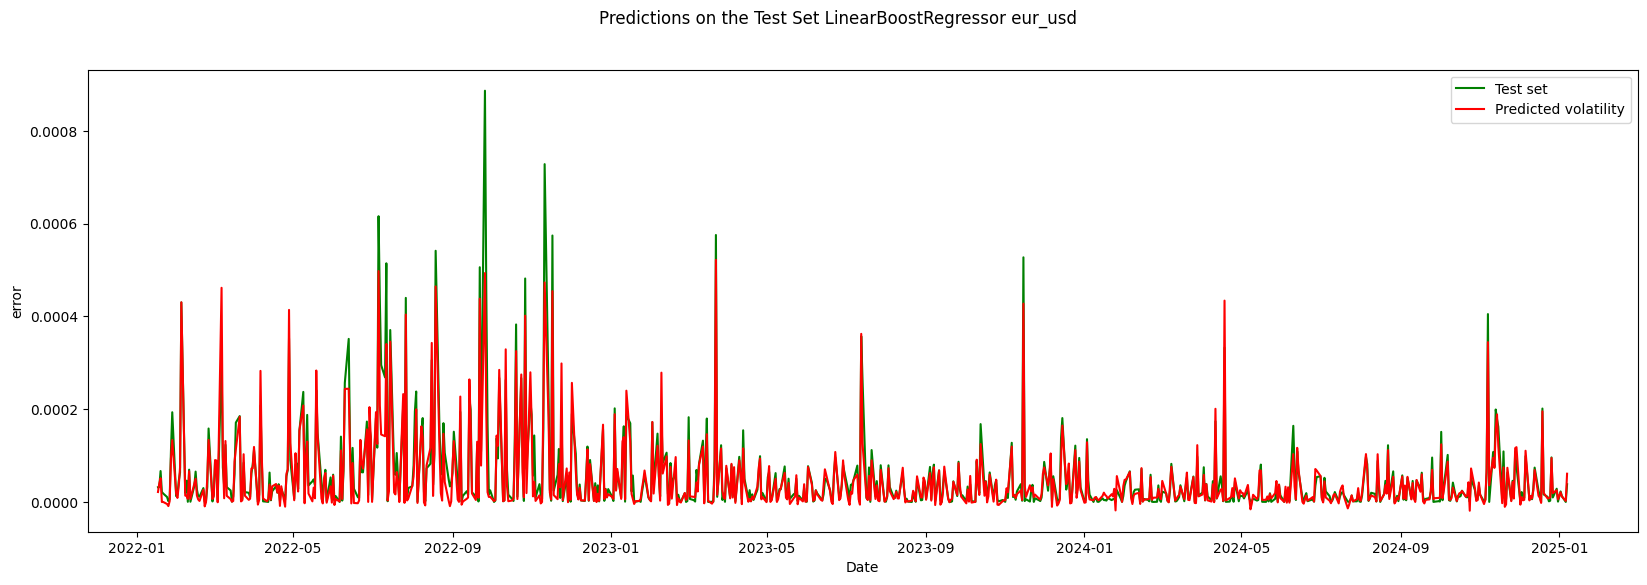

R2 score: 0.8827433312090387
pre feature engineering
residual prediction shape
torch.Size([773, 1])
residual prediction shape
torch.Size([776, 1])
post feature engineering
ae_train_errors
      error  predicted residuals  error_lag1  error_lag2  error_lag3  \
0  0.000070             0.012425         NaN         NaN         NaN   
1  0.000004             0.001441    0.000070         NaN         NaN   
2  0.000007            -0.015022    0.000004    0.000070         NaN   
3  0.000012            -0.015259    0.000007    0.000004    0.000070   
4  0.000003            -0.008474    0.000012    0.000007    0.000004   

   error_rolling_mean_7  error_rolling_std_7  error_diff1  error_diff2  \
0              0.000070                  NaN          NaN          NaN   
1              0.000037             0.000047    -0.000066          NaN   
2              0.000027             0.000037     0.000003     0.000069   
3              0.000023             0.000031     0.000006     0.000003   
4        

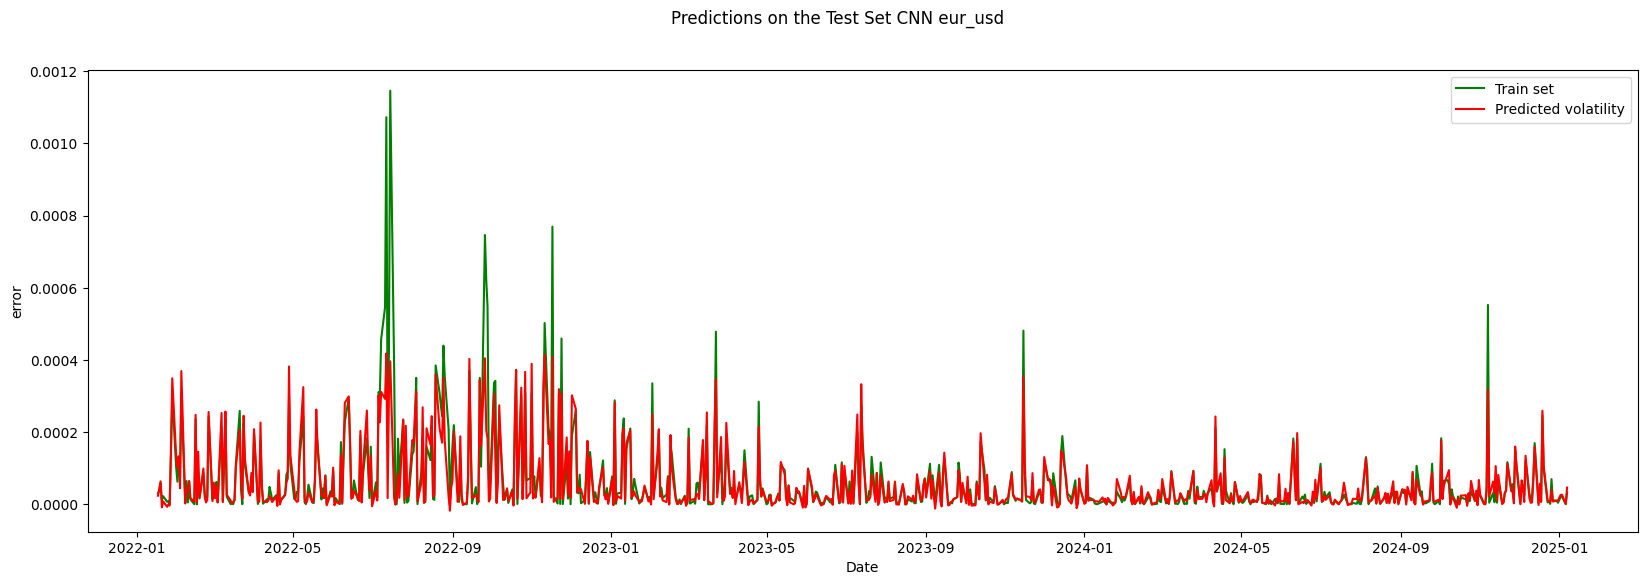

R2 score: 0.7530018091201782


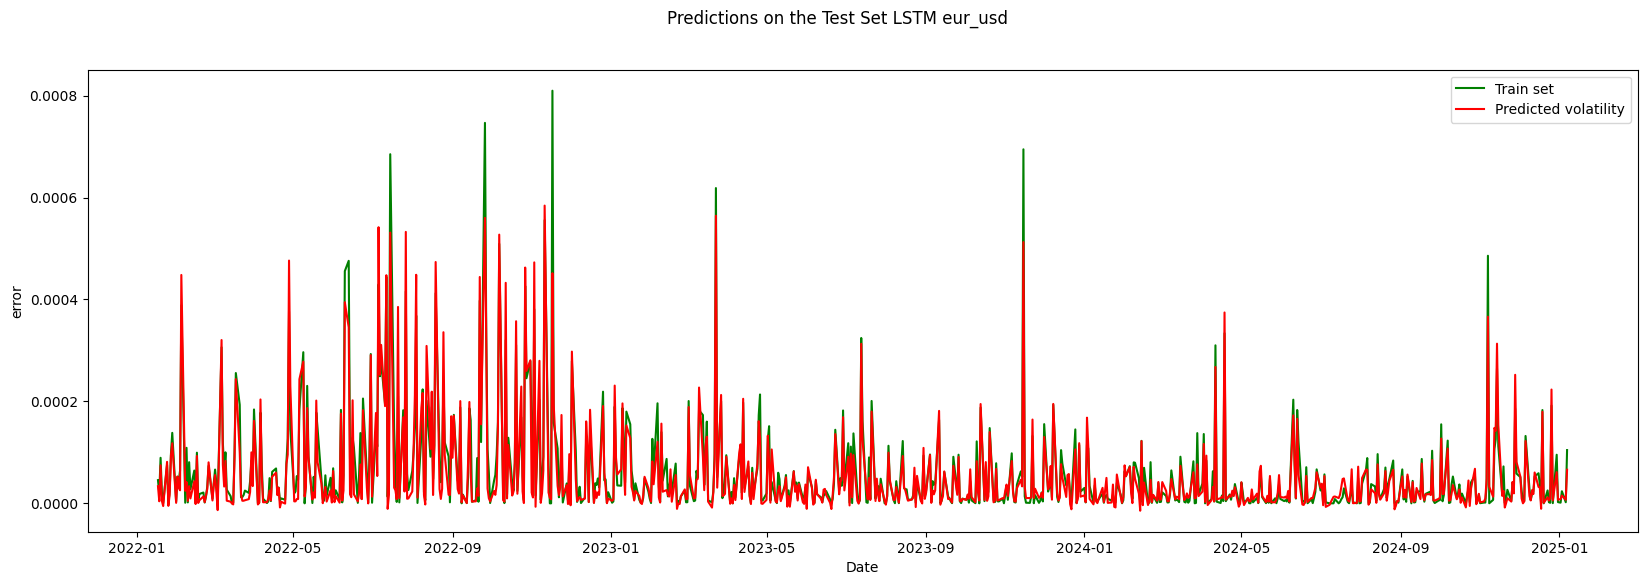

R2 score: 0.8964859247207642


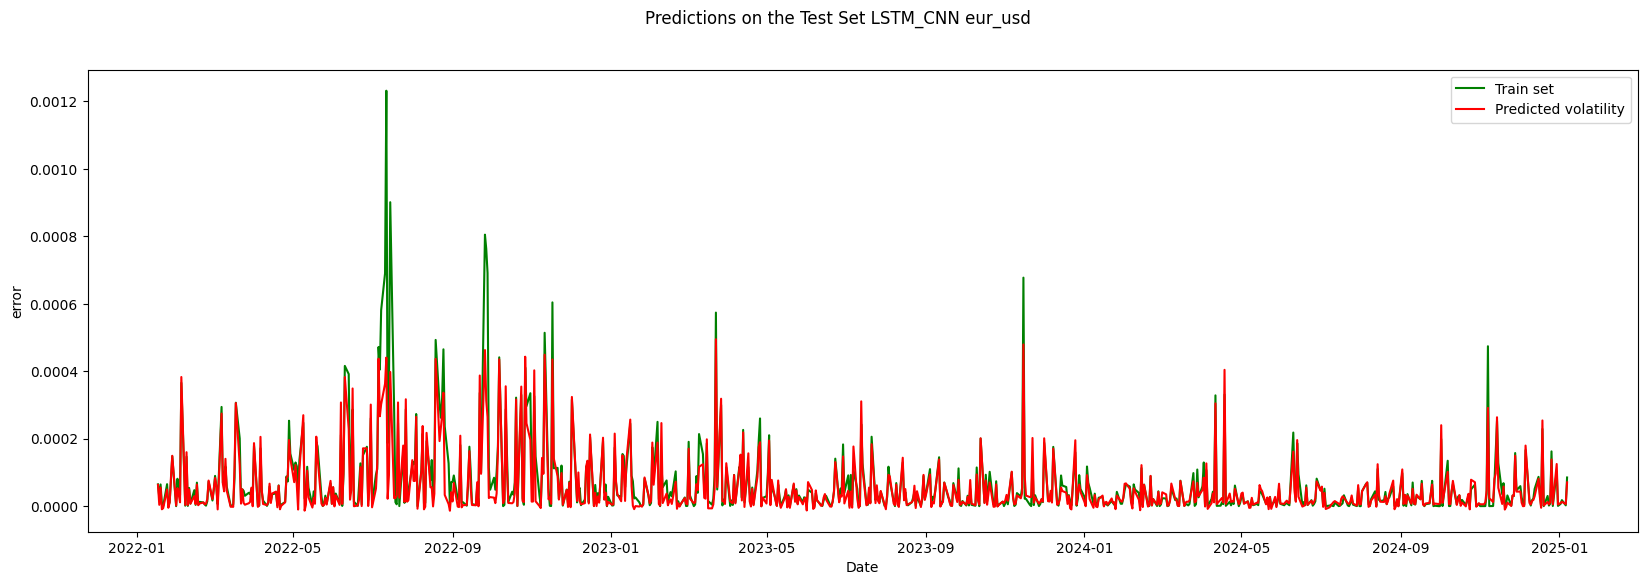

R2 score: 0.7751603722572327


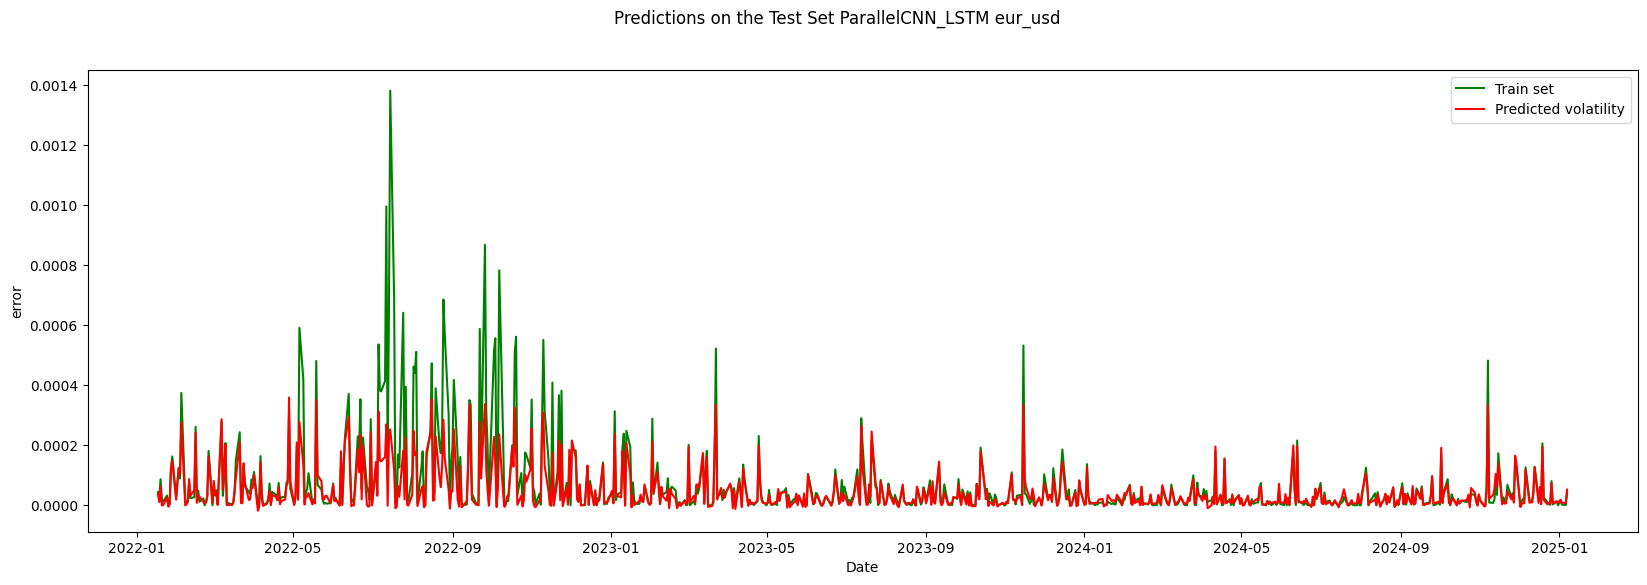

R2 score: 0.5808773040771484
test error predictions
tensor([[2.1460e-05, 2.3634e-05, 3.3583e-05, 6.3073e-05, 3.6411e-05],
        [3.9626e-05, 4.2839e-05, 4.0553e-06, 3.9721e-06, 1.0914e-05],
        [5.1180e-05, 6.3466e-05, 7.4575e-05, 5.4939e-05, 6.2290e-05],
        ...,
        [1.1672e-05, 2.6603e-05, 1.5315e-05, 1.2866e-05, 8.5556e-06],
        [2.2823e-06, 6.6897e-07, 6.9743e-06, 6.3509e-06, 7.4399e-06],
        [6.0885e-05, 4.6356e-05, 6.5981e-05, 7.0420e-05, 5.2034e-05]])
best k errors
tensor([[3.3583e-05, 2.3634e-05, 2.1460e-05, 3.6411e-05, 6.3073e-05],
        [1.0914e-05, 3.9721e-06, 4.0553e-06, 3.9626e-05, 4.2839e-05],
        [6.3466e-05, 5.1180e-05, 6.2290e-05, 5.4939e-05, 7.4575e-05],
        ...,
        [1.5315e-05, 8.5556e-06, 1.1672e-05, 1.2866e-05, 2.6603e-05],
        [6.9743e-06, 6.6897e-07, 2.2823e-06, 6.3509e-06, 7.4399e-06],
        [5.2034e-05, 4.6356e-05, 6.0885e-05, 6.5981e-05, 7.0420e-05]])
std
tensor([[1.6613e-05],
        [1.9375e-05],
        [9.0208e-0

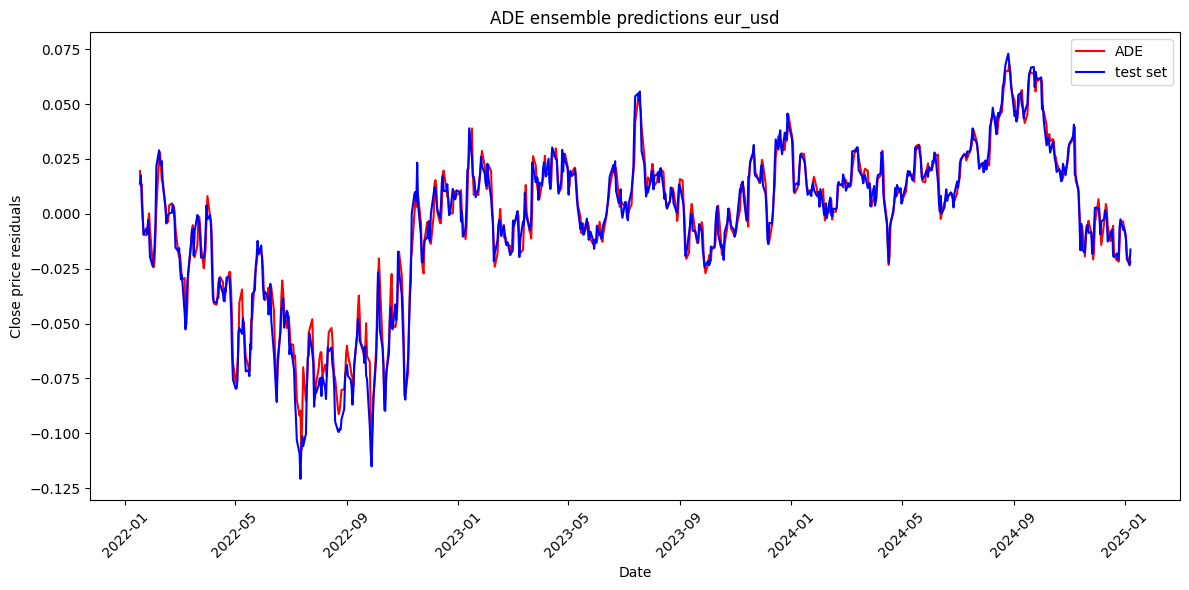

MSE: 4.236319952588994e-05
RMSE: 0.006508701831078908
MAE: 0.004540037358310149
r2:  0.9664970887849303
MAPE: 1.8656067053396035
SMAPE: 0.3688953157543069


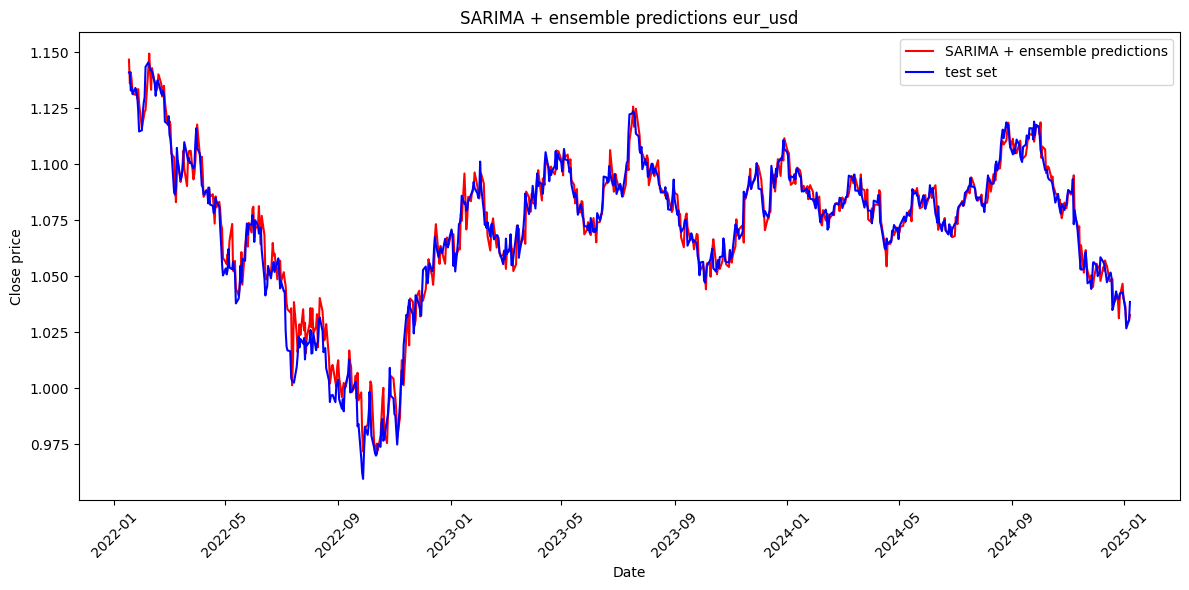

MSE: 4.236319952589101e-05
RMSE: 0.006508701831078991
MAE: 0.004540037358310198
r2:  0.963722972683656
MAPE: 0.004285478828820364
SMAPE: 0.004277786087098559


In [16]:
#using the class
train_data = {}
test_data = {}

trained_models = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]

for name , _ in datasets.items():

    if name == 'sp500':
        continue

    # if name == 'eur_usd':
    #     continue

    print(f"ensembling predictions on {name} dataset:")
    # meta_model = "neural network"
    meta_model = "linear booster"
    train_data[name] = val_residuals[name]
    train_data[name].index = pd.to_datetime(val_residuals[name].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)
    window_size = 10
    error_window = 10

    if name == 'eur_usd':
        k=5
        temperature = 3 #to control weight sharpness

        # k=5
        # temperature = 1.5 #to control weight sharpness
    elif name == 'sp500':
        temperature = 1
        k=3 #number of models to make the ensemble at each time step


    ade = ADE([trained_model[name] for trained_model in trained_models], meta_model, train_data[name], test_data[name], window_size, error_window, k, temperature) #k represent the number of model to select from the batch of models
    final_preds = ade.predict()


    #visualize
    # ensemble_preds = pd.DataFrame(final_preds.detach().numpy(), index = test_data[name][window_size*2:].index)
    ensemble_preds = pd.DataFrame(final_preds.detach().numpy(), index = test_data[name][window_size:].index)
    # ensemble_preds.index = pd.to_datetime(test_data[name][window_size*2:].index)

    plt.figure(figsize=(12, 6))
    plt.title(f"ADE ensemble predictions {name}")
    sns.lineplot(x = ensemble_preds.index, y = ensemble_preds.squeeze(), label = "ADE", color = "red")
    # sns.lineplot(x = test_data[name][window_size*2:].index, y = test_data[name][window_size*2:].squeeze(), label = "test set", color = "blue")
    sns.lineplot(x = test_data[name][window_size:].index, y = test_data[name][window_size:].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price residuals')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    # mse = mean_squared_error(test_data[name][window_size*2:], ensemble_preds)
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error(test_data[name][window_size*2:], ensemble_preds)
    # r2 = r2_score(test_data[name][window_size*2:], ensemble_preds)
    # mape = mean_absolute_percentage_error(test_data[name][window_size*2:], ensemble_preds)
    # smape_value = smape(test_data[name][window_size*2:], ensemble_preds)

    mse = mean_squared_error(test_data[name][window_size:], ensemble_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data[name][window_size:], ensemble_preds)
    r2 = r2_score(test_data[name][window_size:], ensemble_preds)
    mape = mean_absolute_percentage_error(test_data[name][window_size:], ensemble_preds)
    smape_value = smape(test_data[name][window_size:], ensemble_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")


    #combine ensemble predictions with ARIMA model
    final_preds = SARIMA_test_predictions[name][window_size:] + ensemble_preds.iloc[:,0]

    #visualize
    plt.figure(figsize=(12, 6))
    plt.title(f"SARIMA + ensemble predictions {name}")
    sns.lineplot(x = final_preds.index, y = final_preds.squeeze(), label = "SARIMA + ensemble predictions", color = "red")
    sns.lineplot(x = Close_price[name].loc[final_preds.index].index, y = Close_price[name].loc[final_preds.index].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(Close_price[name].loc[final_preds.index], final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Close_price[name].loc[final_preds.index], final_preds)
    r2 = r2_score(Close_price[name].loc[final_preds.index], final_preds)
    mape = mean_absolute_percentage_error(Close_price[name].loc[final_preds.index], final_preds)
    smape_value = smape(Close_price[name].loc[final_preds.index], final_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")

Neural network meta model

ensembling predictions on eur_usd dataset:
test error predictions
tensor([[1.9063e-04, 2.7252e-04, 1.6091e-04, 1.6547e-04, 1.5258e-04],
        [3.0898e-05, 9.7187e-05, 3.5420e-05, 2.8342e-05, 3.6386e-05],
        [3.4761e-05, 8.4533e-05, 8.2013e-05, 1.0795e-04, 8.7685e-05],
        ...,
        [4.8952e-05, 3.8609e-05, 3.3855e-05, 3.4784e-05, 3.4865e-05],
        [3.9877e-05, 4.3063e-05, 5.7441e-05, 4.8780e-05, 2.2614e-05],
        [2.7428e-05, 2.1920e-05, 3.6928e-05, 3.3693e-05, 2.1239e-05]])
best k errors
tensor([[1.6091e-04, 1.5258e-04, 1.6547e-04, 1.9063e-04],
        [3.0898e-05, 2.8342e-05, 3.5420e-05, 3.6386e-05],
        [8.4533e-05, 3.4761e-05, 8.2013e-05, 8.7685e-05],
        ...,
        [3.4865e-05, 3.4784e-05, 3.3855e-05, 3.8609e-05],
        [4.3063e-05, 3.9877e-05, 2.2614e-05, 4.8780e-05],
        [2.1920e-05, 2.1239e-05, 2.7428e-05, 3.3693e-05]])
std
tensor([[1.6395e-05],
        [3.8053e-06],
        [2.5109e-05],
        [3.1959e-05],
        [1.4564e-05],
        [4

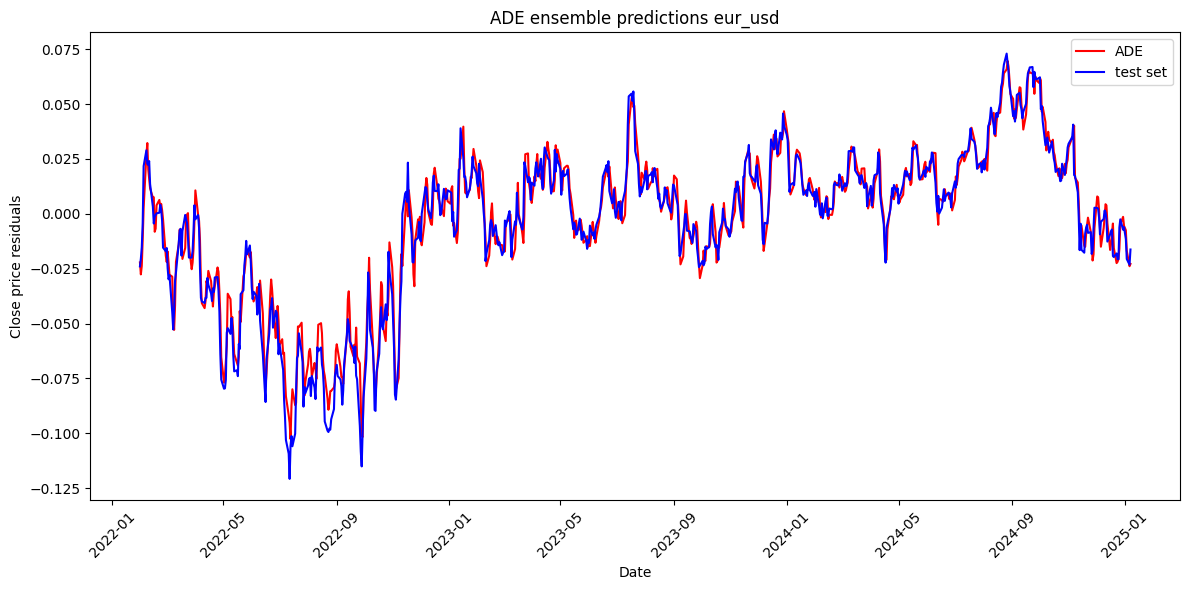

MSE: 5.633500919645386e-05
RMSE: 0.007505665140176043
MAE: 0.0057665818507117205
r2:  0.9559672321831576
MAPE: 2.4906022574191145
SMAPE: 0.4583985913064385


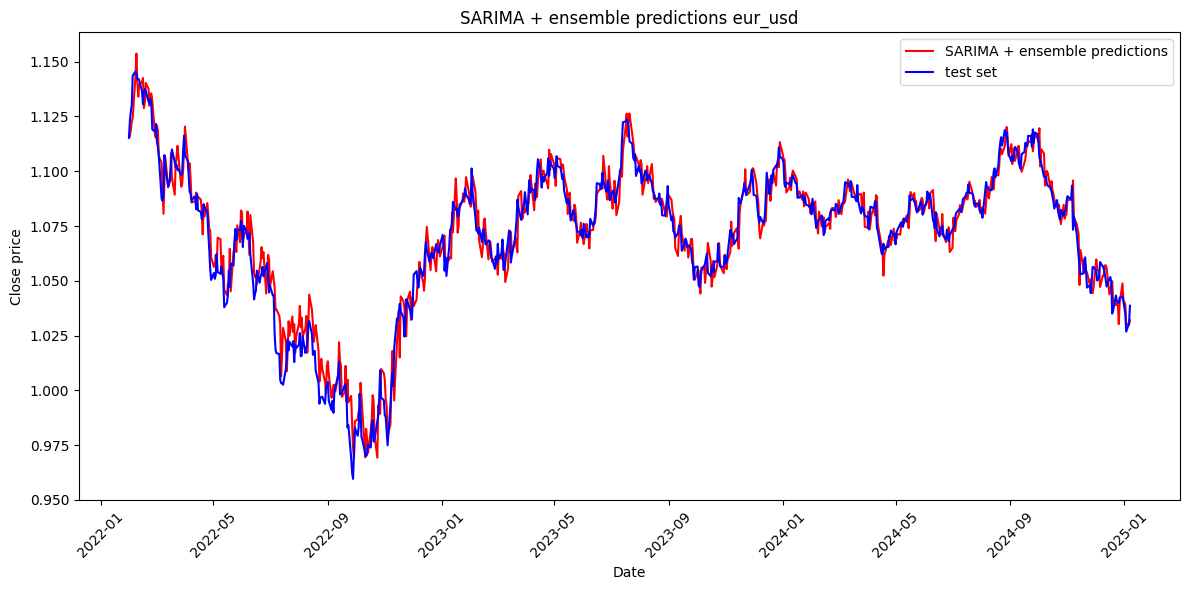

MSE: 5.633500919645504e-05
RMSE: 0.0075056651401761215
MAE: 0.005766581850711766
r2:  0.9503454415966078
MAPE: 0.005438690062259403
SMAPE: 0.00543095659716342


In [ ]:
#using the class
train_data = {}
test_data = {}

trained_models = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]

for name , _ in datasets.items():

    if name == 'sp500':
        continue

    print(f"ensembling predictions on {name} dataset:")
    meta_model = "neural network"
    # meta_model = "linear booster"
    train_data[name] = val_residuals[name]
    train_data[name].index = pd.to_datetime(val_residuals[name].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)
    window_size = 10
    error_window = 10

    if name == 'eur_usd':
        k=4
        temperature = 0.35 #to control weight sharpness
    elif name == 'sp500':
        temperature = 1
        k=3 #number of models to make the ensemble at each time step


    ade = ADE([trained_model[name] for trained_model in trained_models], meta_model, train_data[name], test_data[name], window_size, error_window, k, temperature) #k represent the number of model to select from the batch of models
    final_preds = ade.predict()


    #visualize
    ensemble_preds = pd.DataFrame(final_preds.detach().numpy(), index = test_data[name][window_size*2:].index)
    # ensemble_preds.index = pd.to_datetime(test_data[name][window_size*2:].index)

    plt.figure(figsize=(12, 6))
    plt.title(f"ADE ensemble predictions {name}")
    sns.lineplot(x = ensemble_preds.index, y = ensemble_preds.squeeze(), label = "ADE", color = "red")
    sns.lineplot(x = test_data[name][window_size*2:].index, y = test_data[name][window_size*2:].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price residuals')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(test_data[name][window_size*2:], ensemble_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data[name][window_size*2:], ensemble_preds)
    r2 = r2_score(test_data[name][window_size*2:], ensemble_preds)
    mape = mean_absolute_percentage_error(test_data[name][window_size*2:], ensemble_preds)
    smape_value = smape(test_data[name][window_size*2:], ensemble_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")


    #combine ensemble predictions with ARIMA model
    final_preds = SARIMA_test_predictions[name][window_size*2:] + ensemble_preds.iloc[:,0]

    #visualize
    plt.figure(figsize=(12, 6))
    plt.title(f"SARIMA + ensemble predictions {name}")
    sns.lineplot(x = final_preds.index, y = final_preds.squeeze(), label = "SARIMA + ensemble predictions", color = "red")
    sns.lineplot(x = Close_price[name].loc[final_preds.index].index, y = Close_price[name].loc[final_preds.index].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(Close_price[name].loc[final_preds.index], final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Close_price[name].loc[final_preds.index], final_preds)
    r2 = r2_score(Close_price[name].loc[final_preds.index], final_preds)
    mape = mean_absolute_percentage_error(Close_price[name].loc[final_preds.index], final_preds)
    smape_value = smape(Close_price[name].loc[final_preds.index], final_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")

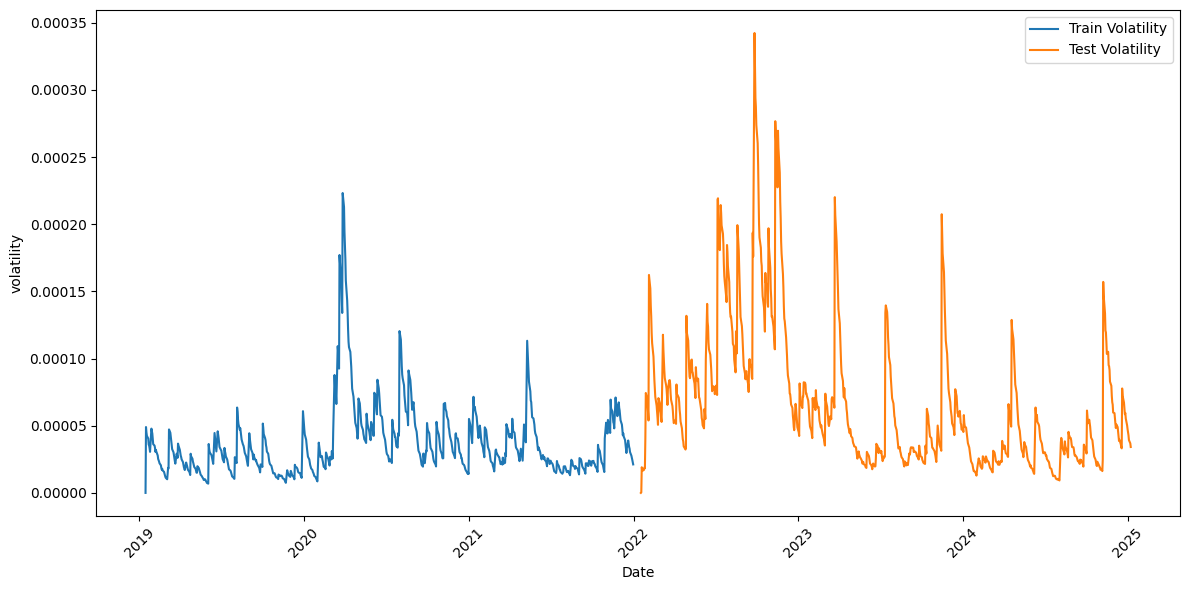

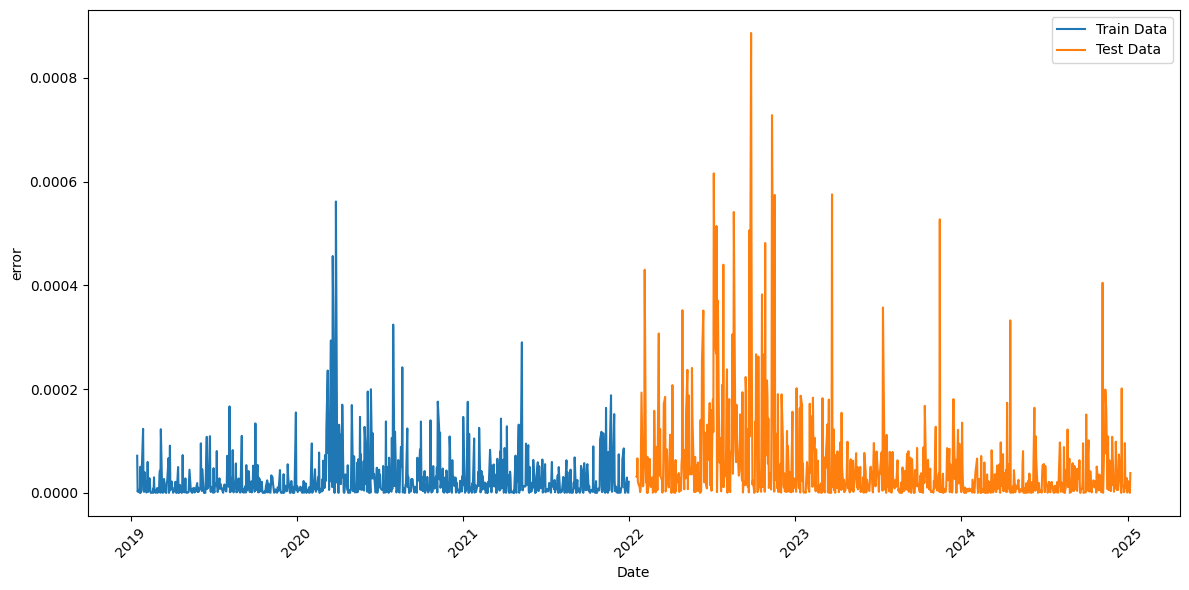

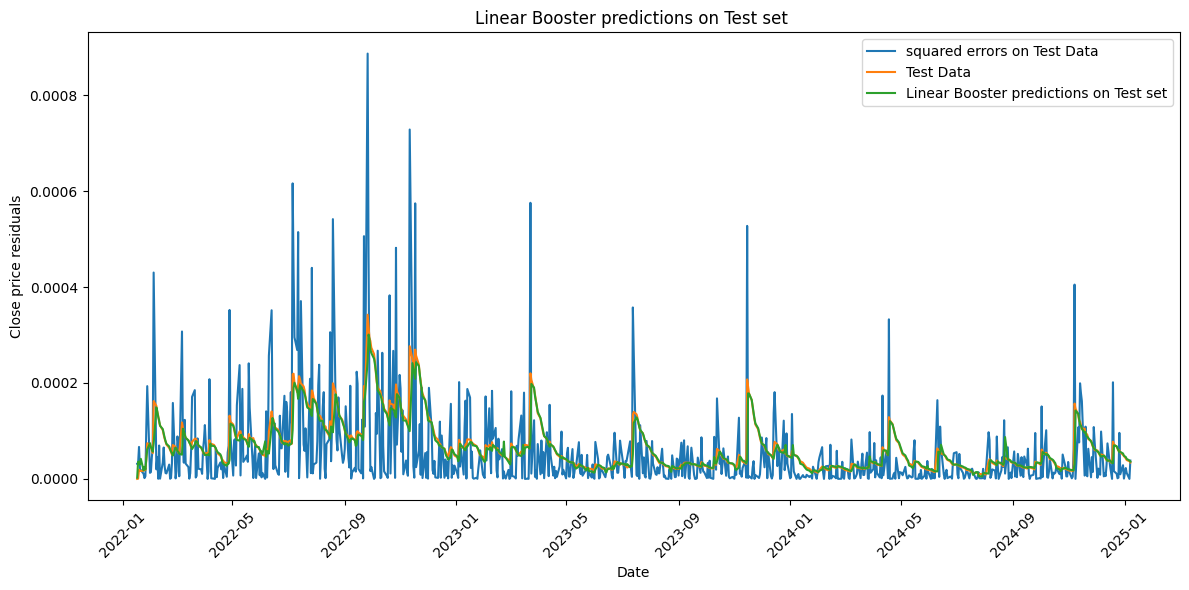

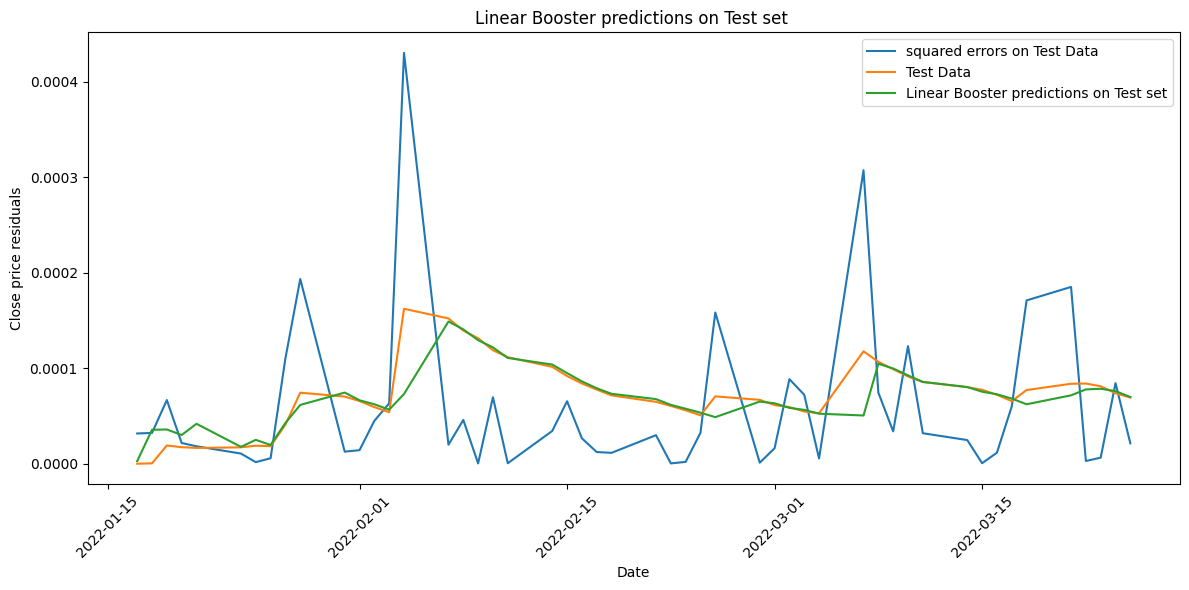

RMSE: 1.6715645800453077e-05
R2: 0.9023995840103356


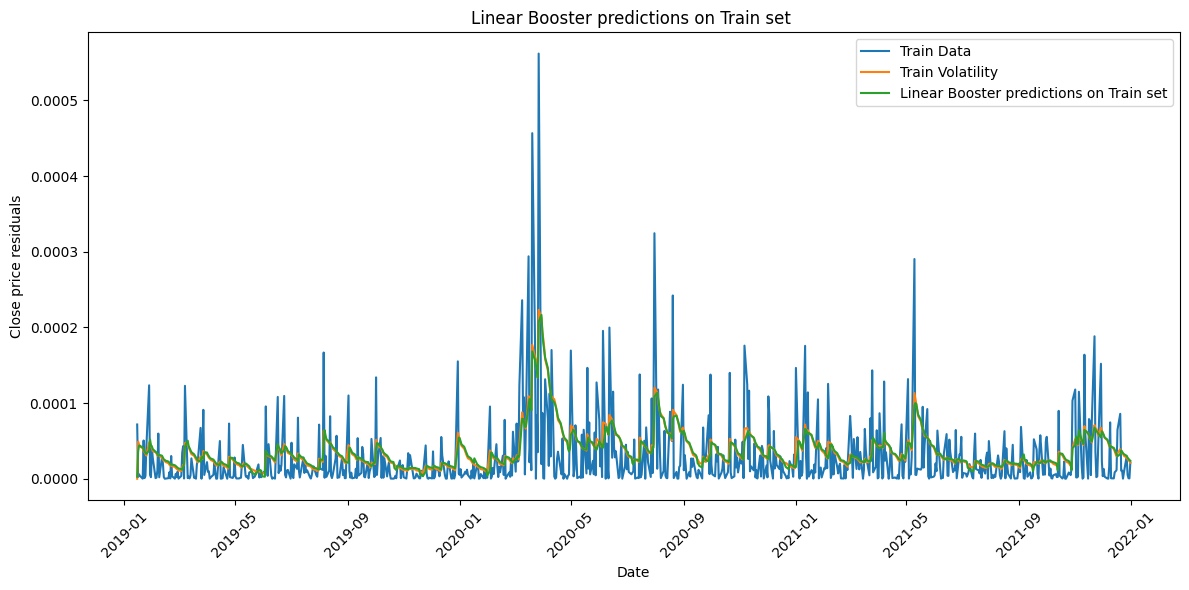

RMSE: 4.683951918887967e-06
R2: 0.9688860134413368


In [127]:
from scipy.stats import median_abs_deviation


# def sliding_windows(data, seq_length):
#     X, y = [], []

#     for i in range(len(data) - seq_length ):
#         _x = data.iloc[i:i+seq_length]
#         _y = data.iloc[i + seq_length]
#         X.append(_x)
#         y.append(_y)

#     return np.array(X), np.array(y)


# def sliding_windows_multifeature(data, seq_length):
#     X, y = [], []
#     for i in range(len(data) - seq_length):
#         _x = data.iloc[i:i+seq_length].values  # extract multiple features as 2D array
#         _y = data.iloc[i + seq_length, 0]  # assuming the target is the first column
#         X.append(_x)
#         y.append(_y)
#     return np.array(X), np.array(y)


def data_preprocessing(dataset, is_train = True):
    # for lag in range(1, 5):
    for lag in range(1, 3):
        dataset[f'lag_{lag}'] = dataset['volatility'].shift(lag)

    # dataset['roll_mean_5'] = dataset['volatility'].shift(1).rolling(window=5).mean()
    if (is_train):
        # dataset['spikes and valleys'] = train_spike_valley_labels.shift(1)
        dataset['spikes and valleys'] = train_spike_valley_labels
    else:
        # dataset['spikes and valleys'] = test_spike_valley_labels.shift(1)
        dataset['spikes and valleys'] = test_spike_valley_labels


    return dataset.fillna(0)



#get errors
train_errors = pd.read_csv("train_errori.csv", index_col=0)
test_errors = pd.read_csv("test_errori.csv", index_col=0)

train_errors.index = pd.to_datetime(train_errors.index)
test_errors.index = pd.to_datetime(test_errors.index)



#compute errors volatility

# train_volatility = train_errors.ewm(span=10, adjust=False).std().fillna(0)
# test_volatility = test_errors.ewm(span=10, adjust=False).std().fillna(0)
train_volatility = train_errors.ewm(span=10, adjust=False).std().fillna(0)
train_volatility.columns = ['volatility']

test_volatility = test_errors.ewm(span=10, adjust=False).std().fillna(0)
test_volatility.columns = ['volatility']


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_volatility.index, y = train_volatility.squeeze(), label="Train Volatility")
sns.lineplot(x=test_volatility.index, y=test_volatility.squeeze(), label="Test Volatility")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#original
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_errors.index, y = train_errors.squeeze(), label="Train Data")
sns.lineplot(x=test_errors.index, y=test_errors.squeeze(), label="Test Data")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#feature engineering
train_volatility = data_preprocessing(train_volatility, True)
test_volatility = data_preprocessing(test_volatility, False)

#scale
scaler = RobustScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train_volatility), index=train_volatility.index, columns=train_volatility.columns)
test_scaled = pd.DataFrame(scaler.transform(test_volatility), index=test_volatility.index, columns=test_volatility.columns)

target_scaler = RobustScaler()
target_scaler.fit(train_volatility[['volatility']])


#X, y
X_train, y_train = train_scaled.drop('volatility', axis=1), train_scaled['volatility']
X_test, y_test = test_scaled.drop('volatility', axis=1), test_scaled['volatility']


#train model
# best_params = {"n_estimators": 5,  "max_depth": 20,  "min_samples_split" : 10, "min_samples_leaf" : 0.0002 }
best_params = {"n_estimators": 50,  "max_depth": 20,  "min_samples_split" : 10, "min_samples_leaf" : 0.0002 }
ridge = Ridge(alpha=3)
model = LinearBoostRegressor(base_estimator=ridge, **best_params)
model.fit(X_train, y_train)


#predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


#unscale
y_test_pred = pd.DataFrame(target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)), index = test_volatility.index)
y_train_pred = pd.DataFrame(target_scaler.inverse_transform(y_train_pred.reshape(-1, 1)), index = train_volatility.index)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_errors.index, y=test_errors.squeeze(), label="squared errors on Test Data")
sns.lineplot(x= test_volatility['volatility'].index, y = test_volatility['volatility'].squeeze(), label="Test Data")
sns.lineplot(x=test_volatility.index, y=y_test_pred.squeeze(), label="Linear Booster predictions on Test set")
# sns.lineplot(x=mad_volatility.index, y=mad_volatility.squeeze(), label="Linear Booster predictions on Train set")
plt.title(f'Linear Booster predictions on Test set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_errors[:50].index, y=test_errors[:50].squeeze(), label="squared errors on Test Data")
sns.lineplot(x= test_volatility['volatility'][:50].index, y = test_volatility['volatility'][:50].squeeze(), label="Test Data")
sns.lineplot(x=test_volatility[:50].index, y=y_test_pred[:50].squeeze(), label="Linear Booster predictions on Test set")
plt.title(f'Linear Booster predictions on Test set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
rmse = np.sqrt(mean_squared_error(test_volatility['volatility'], y_test_pred))
r2 = r2_score(test_volatility['volatility'], y_test_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")



#fitted values
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_errors.index, y = train_errors.squeeze(), label="Train Data")
sns.lineplot(x= train_volatility['volatility'].index, y = train_volatility['volatility'].squeeze(), label="Train Volatility")
sns.lineplot(x=train_errors.index, y=y_train_pred.squeeze(), label="Linear Booster predictions on Train set")
plt.title(f'Linear Booster predictions on Train set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#compute metrics
rmse = np.sqrt(mean_squared_error(train_volatility['volatility'], y_train_pred))
r2 = r2_score(train_volatility['volatility'], y_train_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

predicted_test_volatility = pd.DataFrame(y_test_pred, index = test_volatility.index)
predicted_train_volatility = pd.DataFrame(y_train_pred, index = train_volatility.index)

Train volatility spikes and valley

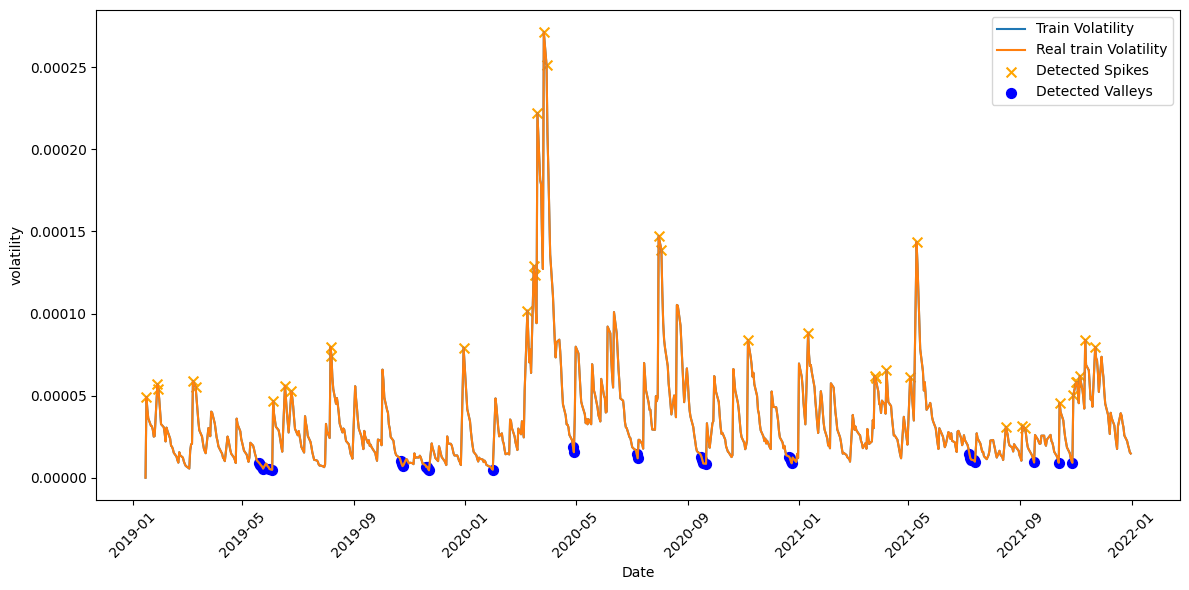

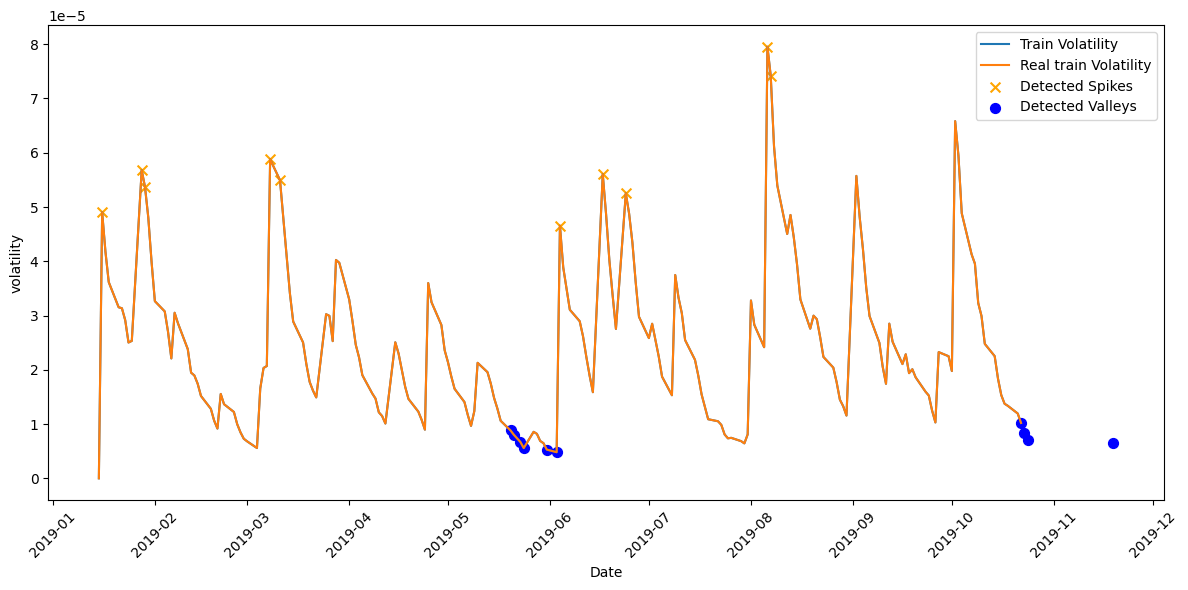

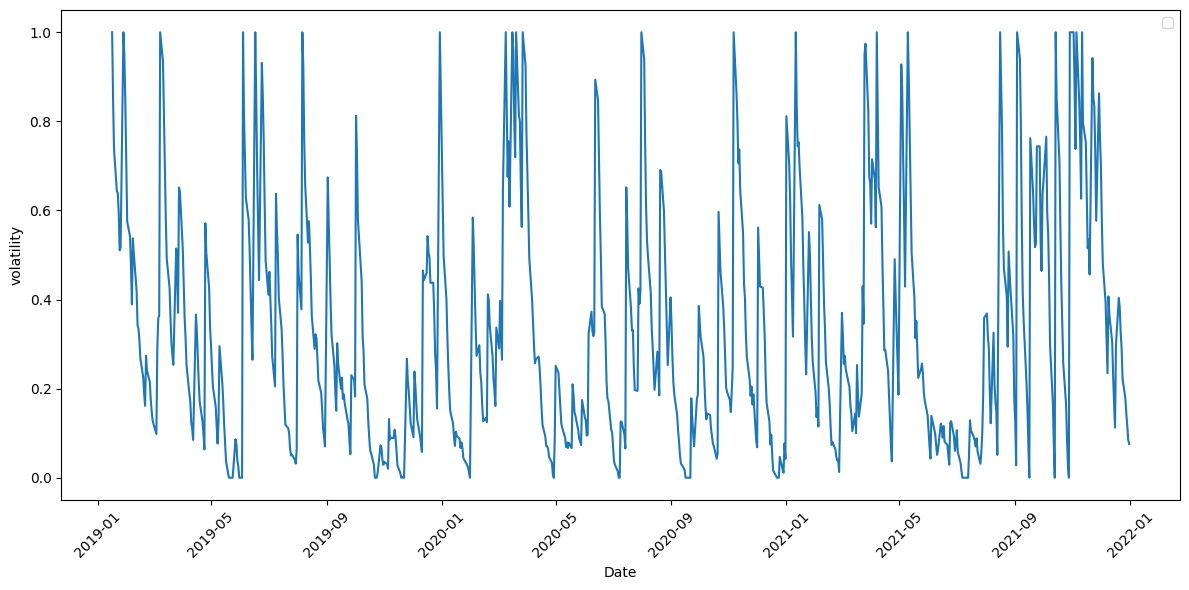

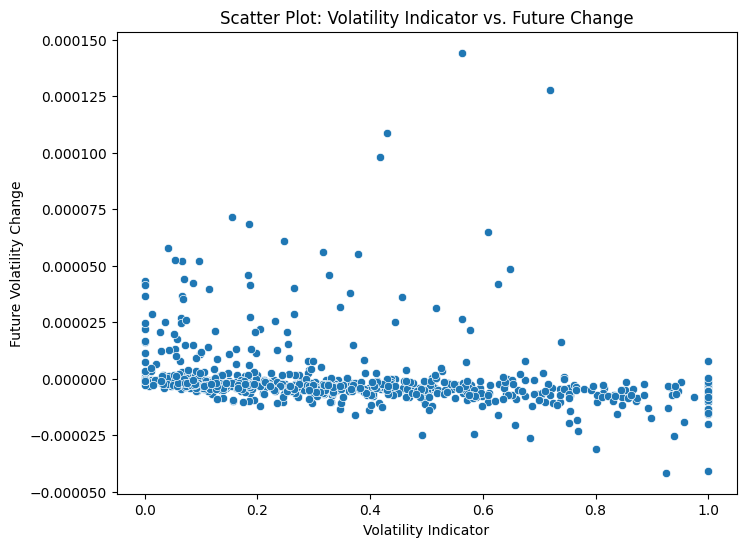

In [116]:
import numpy as np
import pandas as pd
# import talib

# real_train_volatility = train_errors.ewm(span=5, adjust=False).std().fillna(0)
# real_train_volatility.columns = ['volatility']

train_volatility = train_errors.ewm(span=5, adjust=False).std().fillna(0)
train_volatility.columns = ['volatility']

test_volatility = test_errors.ewm(span=5, adjust=False).std().fillna(0)
test_volatility.columns = ['volatility']

lookback = 50

vol_max = train_volatility.rolling(window=lookback, min_periods=1).max()
vol_min = train_volatility.rolling(window=lookback, min_periods=1).min()

# Calculate the relative position of the current volatility
volatility_indicator = (train_volatility - vol_min) / (vol_max - vol_min)
volatility_indicator = pd.Series(volatility_indicator.squeeze())

#identify spikes
spike_indices = train_volatility.index[volatility_indicator > 0.9]
spike_values = train_volatility.loc[spike_indices, 'volatility']

#identify valleys
valley_indices = train_volatility.index[volatility_indicator < 0.01]
valley_values = train_volatility.loc[valley_indices, 'volatility']


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_volatility.index, y = train_volatility.squeeze(), label="Train Volatility")
sns.lineplot(x=real_train_volatility.index, y=real_train_volatility.squeeze(), label="Real train Volatility")
plt.scatter(spike_indices, spike_values, color='orange', s=50, label="Detected Spikes", marker='x')
plt.scatter(valley_indices, valley_values, color='blue', s=50, label="Detected Valleys", marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_volatility[:200].index, y = train_volatility[:200].squeeze(), label="Train Volatility")
sns.lineplot(x=real_train_volatility[:200].index, y=real_train_volatility[:200].squeeze(), label="Real train Volatility")
plt.scatter(spike_indices[:10], spike_values[:10], color='orange', s=50, label="Detected Spikes", marker='x')
plt.scatter(valley_indices[:10], valley_values[:10], color='blue', s=50, label="Detected Valleys", marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# sns.lineplot(x= train_volatility.index, y = train_volatility.squeeze(), label="Train Volatility")
sns.lineplot(data=volatility_indicator)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


# Define the forecast horizon (in time steps)
forward_shift = 1

# Compute the future change in volatility
future_change = train_volatility.shift(-forward_shift) - train_volatility

# Remove the last forward_shift rows from the indicator and future_change for alignment
aligned_indicator = volatility_indicator.iloc[:-forward_shift]
aligned_future_change = future_change.iloc[:-forward_shift]


#visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=aligned_indicator.squeeze(), y=aligned_future_change.squeeze())
plt.xlabel("Volatility Indicator")
plt.ylabel("Future Volatility Change")
plt.title("Scatter Plot: Volatility Indicator vs. Future Change")
plt.show()


# Create a new dataset (Series) for spikes and valleys
train_spike_valley_labels = pd.Series(0, index=train_volatility.index)  # Initialize with 0

# Assign labels
train_spike_valley_labels[volatility_indicator > 0.9] = 1  # Spikes
train_spike_valley_labels[volatility_indicator < 0.01] = -1  # Valleys



Test volatility spikes and valley

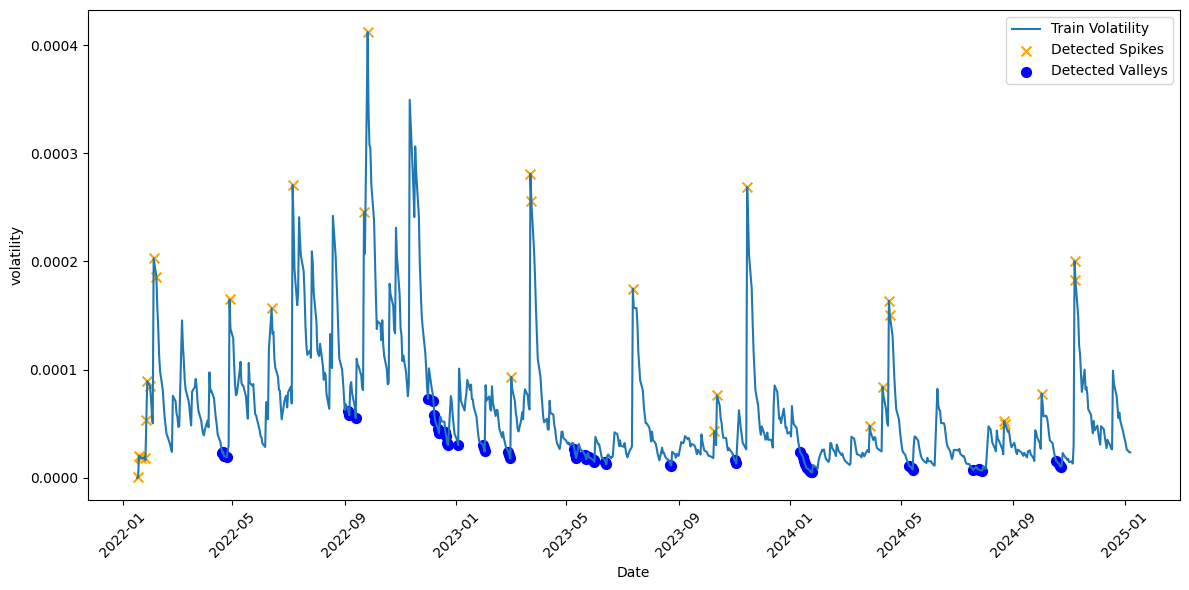

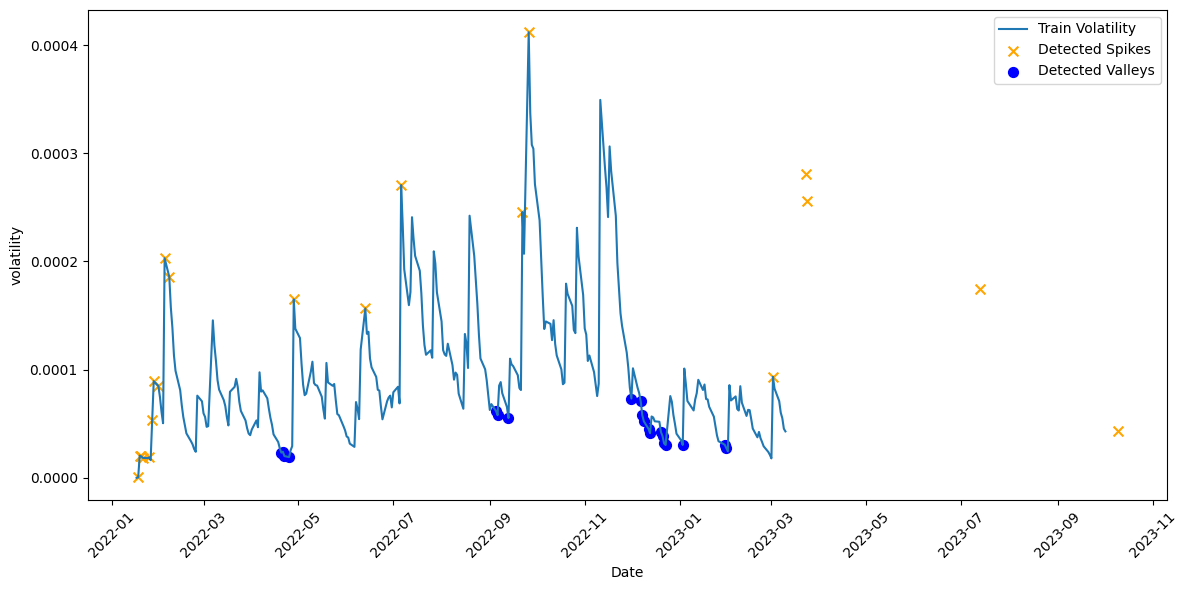

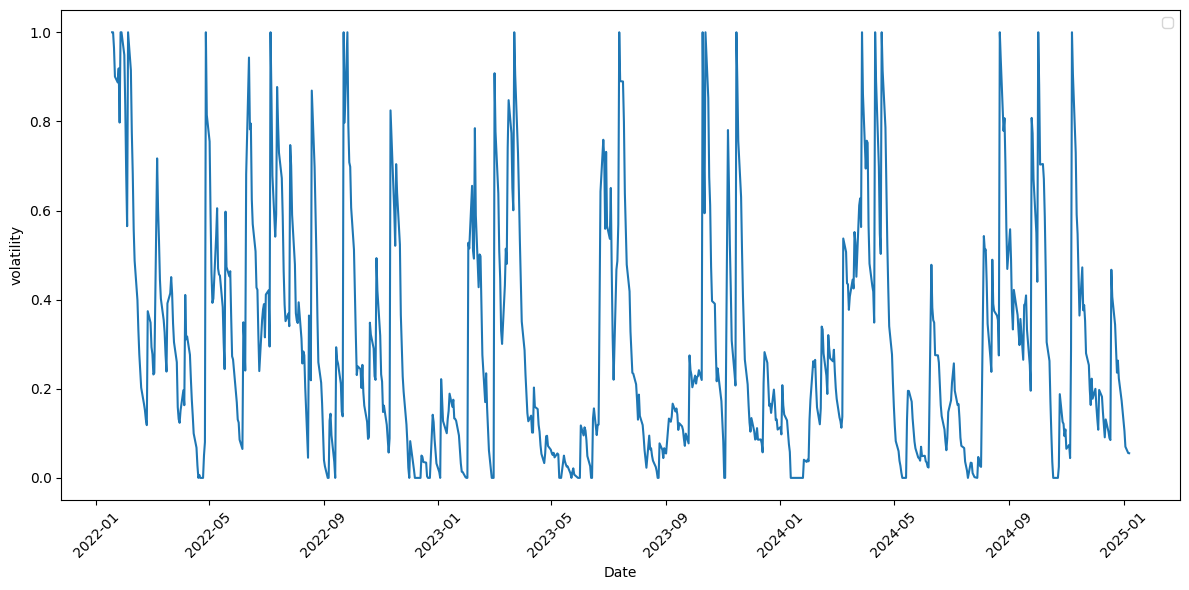

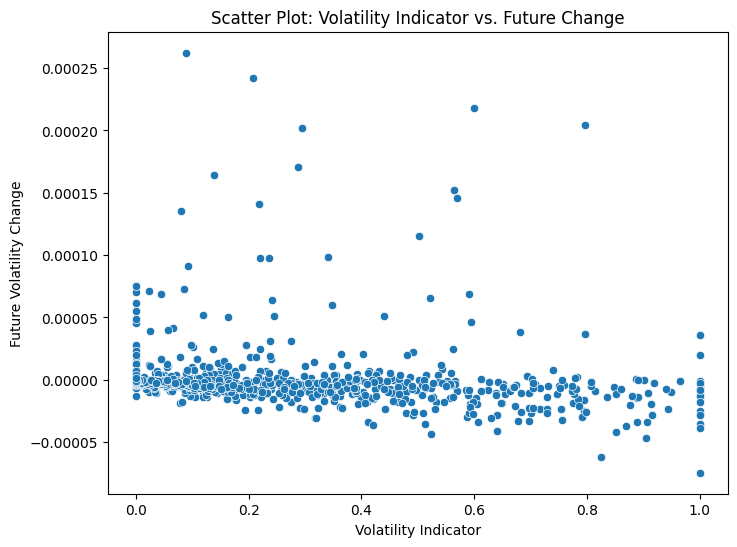

In [118]:
import numpy as np
import pandas as pd

test_volatility = test_errors.ewm(span=5, adjust=False).std().fillna(0)
test_volatility.columns = ['volatility']

lookback = 50

vol_max = test_volatility.rolling(window=lookback, min_periods=1).max()
vol_min = test_volatility.rolling(window=lookback, min_periods=1).min()

# Calculate the relative position of the current volatility
volatility_indicator = (test_volatility - vol_min) / (vol_max - vol_min)
volatility_indicator = pd.Series(volatility_indicator.squeeze())

#identify spikes
spike_indices = test_volatility.index[(volatility_indicator > 0.9) & (volatility_indicator < 2)]
spike_values = test_volatility.loc[spike_indices, 'volatility']

#identify valleys
valley_indices = test_volatility.index[volatility_indicator < 0.01]
valley_values = test_volatility.loc[valley_indices, 'volatility']


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= test_volatility.index, y = test_volatility.squeeze(), label="Train Volatility")
plt.scatter(spike_indices, spike_values, color='orange', s=50, label="Detected Spikes", marker='x')
plt.scatter(valley_indices, valley_values, color='blue', s=50, label="Detected Valleys", marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x= test_volatility[:300].index, y = test_volatility[:300].squeeze(), label="Train Volatility")
plt.scatter(spike_indices[:20], spike_values[:20], color='orange', s=50, label="Detected Spikes", marker='x')
plt.scatter(valley_indices[:20], valley_values[:20], color='blue', s=50, label="Detected Valleys", marker='o')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# sns.lineplot(x= test_volatility.index, y = test_volatility.squeeze(), label="Train Volatility")
sns.lineplot(data=volatility_indicator)
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


# Define the forecast horizon (in time steps)
forward_shift = 1

# Compute the future change in volatility
future_change = test_volatility.shift(-forward_shift) - test_volatility

# Remove the last forward_shift rows from the indicator and future_change for alignment
aligned_indicator = volatility_indicator.iloc[:-forward_shift]
aligned_future_change = future_change.iloc[:-forward_shift]


#visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(x=aligned_indicator.squeeze(), y=aligned_future_change.squeeze())
plt.xlabel("Volatility Indicator")
plt.ylabel("Future Volatility Change")
plt.title("Scatter Plot: Volatility Indicator vs. Future Change")
plt.show()


# Create a new dataset (Series) for spikes and valleys
test_spike_valley_labels = pd.Series(0, index=test_volatility.index)  # Initialize with 0

# Assign labels
test_spike_valley_labels[(volatility_indicator > 0.9) & (volatility_indicator < 2)] = 1  # Spikes
test_spike_valley_labels[volatility_indicator < 0.01] = -1  # Valleys

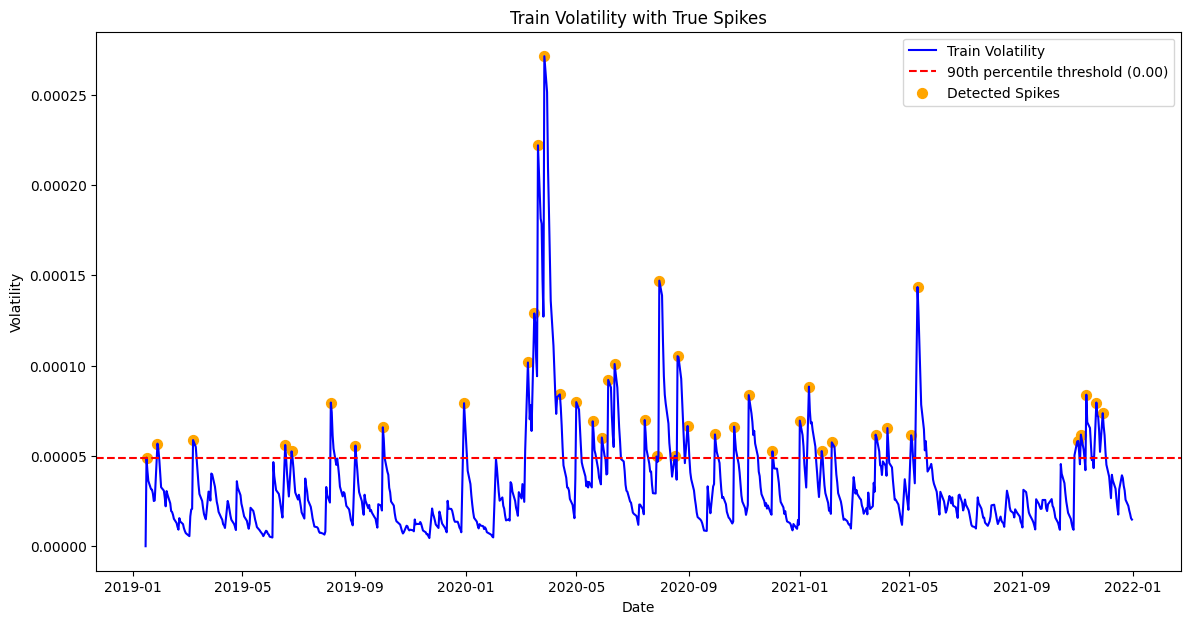

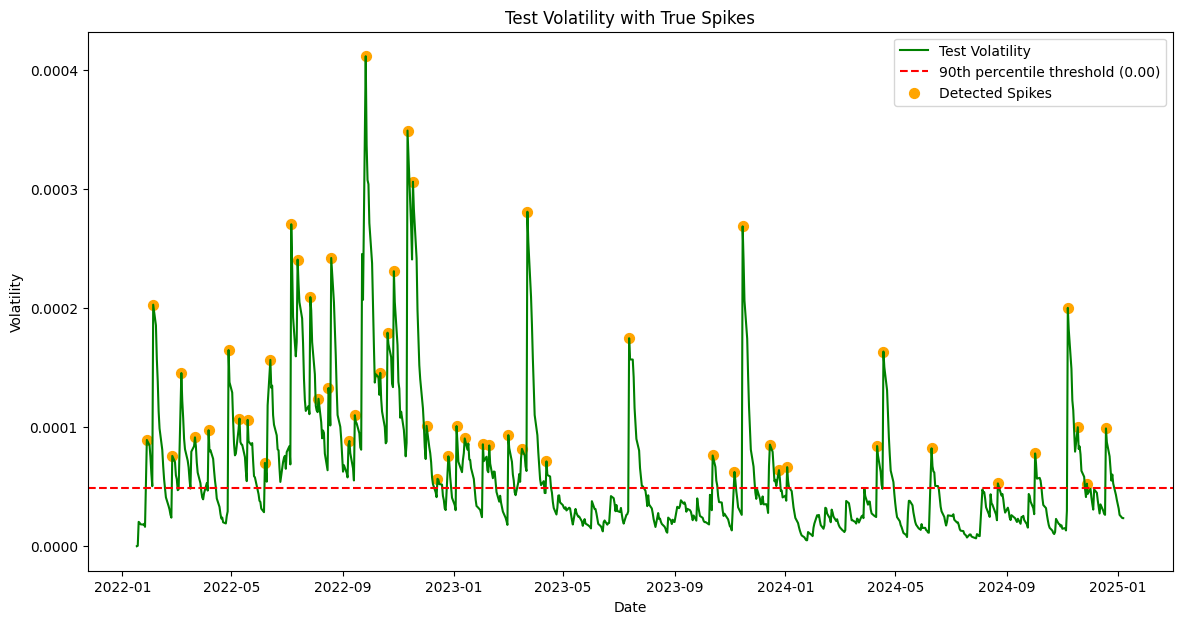

            volatility_lag_1  error_abs_lag_1  volatility_lag_2  \
Date                                                              
2019-01-15          0.000000         0.000000          0.000000   
2019-01-16          0.000000         0.000072          0.000000   
2019-01-17          0.000049         0.000002          0.000000   
2019-01-18          0.000042         0.000006          0.000049   
2019-01-21          0.000036         0.000004          0.000042   

            error_abs_lag_2  volatility_lag_3  error_abs_lag_3  \
Date                                                             
2019-01-15         0.000000          0.000000         0.000000   
2019-01-16         0.000000          0.000000         0.000000   
2019-01-17         0.000072          0.000000         0.000000   
2019-01-18         0.000002          0.000000         0.000072   
2019-01-21         0.000006          0.000049         0.000002   

            volatility_lag_4  error_abs_lag_4  volatility_lag_5  \


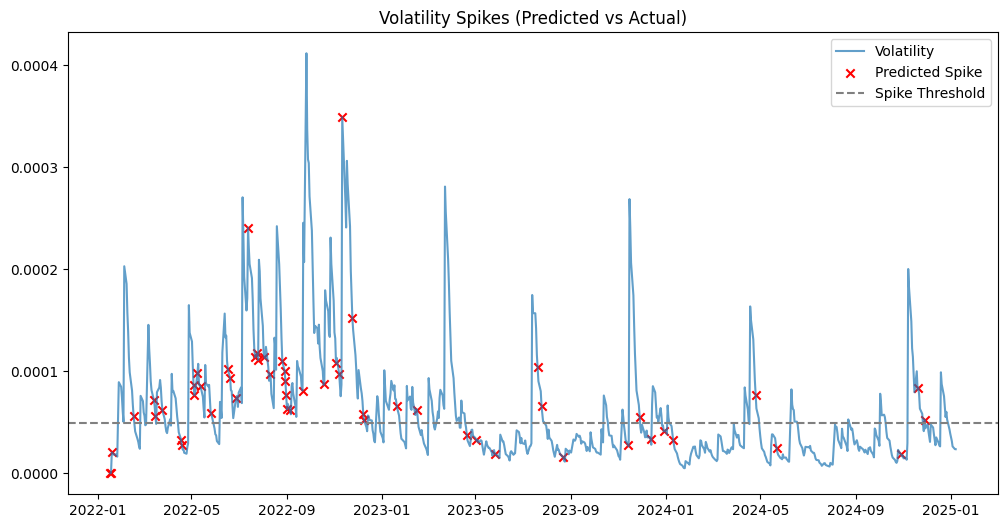

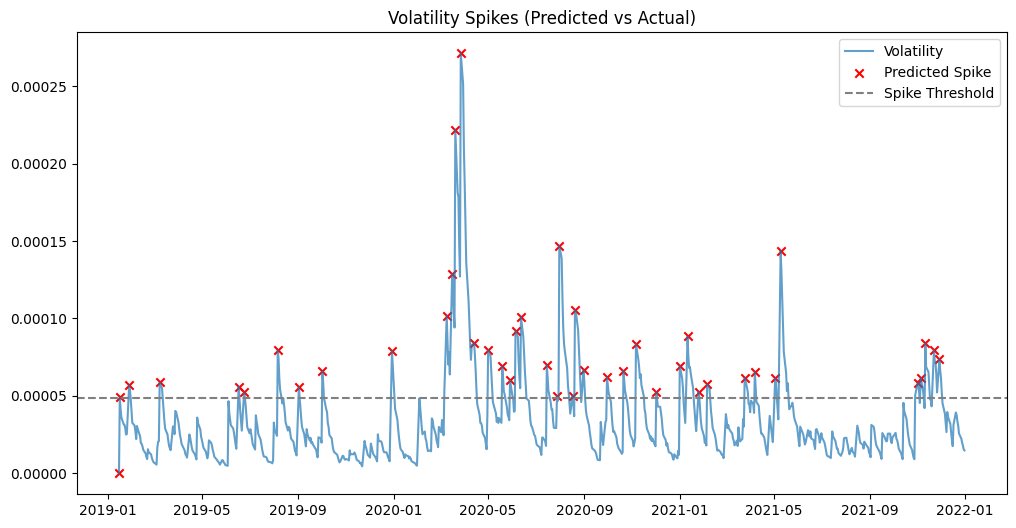

In [ ]:
#anomaly detection
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from scipy.signal import argrelextrema
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import IsolationForest



#get errors
train_errors = pd.read_csv("train_errori.csv", index_col=0)
test_errors = pd.read_csv("test_errori.csv", index_col=0)

train_errors.index = pd.to_datetime(train_errors.index)
test_errors.index = pd.to_datetime(test_errors.index)


#compute errors volatility
train_volatility = train_errors.ewm(span=5, adjust=False).std().fillna(0)
train_volatility.columns = ['volatility']

test_volatility = test_errors.ewm(span=5, adjust=False).std().fillna(0)
test_volatility.columns = ['volatility']


#define spikes
# spike_threshold = np.quantile(train_volatility['volatility'], 0.95)

# # Create binary labels for train/test
# train_labels = (train_volatility['volatility'] >= spike_threshold).astype(int)
# test_labels = (test_volatility['volatility'] >= spike_threshold).astype(int)

spike_threshold = np.quantile(train_volatility['volatility'], 0.80)

# Find local maxima in train volatility
local_maxima_idx = argrelextrema(train_volatility['volatility'].values, np.greater, order=2)[0]

# Keep only the local maxima that exceed the threshold
spike_indices_train = local_maxima_idx[train_volatility.iloc[local_maxima_idx]['volatility'] > spike_threshold]

# Create a binary label series (spikes = 1, else 0)
train_labels = np.zeros(len(train_volatility), dtype=int)
train_labels[spike_indices_train] = 1
train_labels = pd.Series(train_labels, index=train_volatility.index)

# Repeat the process for test volatility
local_maxima_idx_test = argrelextrema(test_volatility['volatility'].values, np.greater, order=2)[0]
spike_indices_test = local_maxima_idx_test[test_volatility.iloc[local_maxima_idx_test]['volatility'] > spike_threshold]

test_labels = np.zeros(len(test_volatility), dtype=int)
test_labels[spike_indices_test] = 1
test_labels = pd.Series(test_labels, index=test_volatility.index)



# Plot the results for train
plt.figure(figsize=(14, 7))
plt.plot(train_volatility.index, train_volatility['volatility'], label="Train Volatility", color='blue')
plt.axhline(y=spike_threshold, color='red', linestyle='--', label=f"90th percentile threshold ({spike_threshold:.2f})")
plt.scatter(train_volatility.index[train_labels == 1], train_volatility['volatility'][train_labels == 1],
            color='orange', s=50, label="Detected Spikes")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Train Volatility with True Spikes")
plt.legend()
plt.show()

# Plot the results for test
plt.figure(figsize=(14, 7))
plt.plot(test_volatility.index, test_volatility['volatility'], label="Test Volatility", color='green')
plt.axhline(y=spike_threshold, color='red', linestyle='--', label=f"90th percentile threshold ({spike_threshold:.2f})")
plt.scatter(test_volatility.index[test_labels == 1], test_volatility['volatility'][test_labels == 1],
            color='orange', s=50, label="Detected Spikes")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Test Volatility with True Spikes")
plt.legend()
plt.show()


# #visualize
# plt.figure(figsize=(14, 7))
# plt.plot(train_volatility.index, train_volatility['volatility'], label="Train Volatility", color='blue')

# plt.axhline(y=spike_threshold, color='red', linestyle='--', label=f"90th percentile threshold ({spike_threshold:.2f})") #spike threshold line

# # Highlight the spikes (points above the threshold)
# spike_points = train_volatility.index[train_labels == 1]
# plt.scatter(spike_points, train_volatility.loc[spike_points, 'volatility'],  color='orange', s=50, label="Spikes")
# plt.xlabel("Date")
# plt.ylabel("Volatility")
# plt.title("Train Volatility with Spikes")
# plt.legend()
# plt.show()


def create_features(errors, volatility, lags=7):  # Increase lags to 7
    df = pd.DataFrame({'error': errors, 'volatility': volatility})

    # Lagged features (t-1 to t-7)
    for lag in range(1, lags+1):
        df[f'volatility_lag_{lag}'] = df['volatility'].shift(lag)
        df[f'error_abs_lag_{lag}'] = np.abs(df['error']).shift(lag)

    # Rolling features with multiple windows
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df['volatility'].rolling(window).mean().shift(1)
        df[f'rolling_std_{window}'] = df['volatility'].rolling(window).std().shift(1)
        df[f'vol_zscore_{window}'] = (df['volatility_lag_1'] - df[f'rolling_mean_{window}']) / df[f'rolling_std_{window}']

    # Volatility changes and acceleration
    df['volatility_change'] = df['volatility_lag_1'] - df['volatility_lag_2']
    df['volatility_acceleration'] = df['volatility_change'] - df['volatility_lag_1'].diff().shift(1)

    # Exponential moving averages
    df['ema_5'] = df['volatility'].ewm(span=5).mean().shift(1)
    df['ema_10'] = df['volatility'].ewm(span=10).mean().shift(1)

    # Drop raw data and handle NaNs
    df = df.drop(columns=['error', 'volatility'])
    df = df.fillna(method='ffill').fillna(0).replace([np.inf, -np.inf], 0)

    return df

# Create feature matrices
X_train = create_features(train_errors.iloc[:,0], train_volatility['volatility'])
X_test = create_features(test_errors.iloc[:,0], test_volatility['volatility'])

X_train= X_train.fillna(0)
X_test = X_test.fillna(0)

print(X_train.head())

# Align labels with features
y_train = train_labels.loc[X_train.index]
y_test = test_labels.loc[X_test.index]

print(y_train[y_train == 1].head())


#model
# best_params = {"n_estimators": 100,  "max_depth": 11,  "min_samples_split" : 5, "min_samples_leaf" : 0.01}
# ridge = Ridge(alpha=1)

# model = LinearBoostClassifier(base_estimator=ridge, **best_params)
# model.fit(X_train, y_train)
# neg, pos = np.bincount(y_train)
# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight=neg/pos,  # Critical for imbalance
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.1,
#     eval_metric='aucpr'
# )

print("Original class distribution:")
print(y_train.value_counts())

# Upsample the minority class using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("\nAfter resampling:")
print(pd.Series(y_train_res).value_counts())

# model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     scale_pos_weight=neg/pos,  # Critical for imbalance
#     n_estimators=200,
#     max_depth=3,
#     learning_rate=0.1,
#     eval_metric='aucpr'
# )


model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    eval_metric='aucpr'
)
# # model.fit(X_train, y_train)


model.fit(X_train_res, y_train_res)


#predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


#metrics
# Compute classification metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Compute confusion matrices
print("Train Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


#visualize
# Plot volatility
plt.figure(figsize=(12, 6))
plt.plot(test_volatility.index, test_volatility['volatility'], label='Volatility', alpha=0.7)

# Overlay predicted spikes (1s)
spike_indices = test_volatility.index[y_test_pred == 1]
plt.scatter(spike_indices, test_volatility.loc[spike_indices, 'volatility'], color='red', marker='x', label='Predicted Spike')

# Add threshold line
plt.axhline(y=spike_threshold, color='gray', linestyle='--', label='Spike Threshold')

plt.title('Volatility Spikes (Predicted vs Actual)')
plt.legend()
plt.show()





# Plot volatility
plt.figure(figsize=(12, 6))
plt.plot(train_volatility.index, train_volatility['volatility'], label='Volatility', alpha=0.7)

# Overlay predicted spikes (1s)
spike_indices = train_volatility.index[y_train_pred == 1]
plt.scatter(spike_indices, train_volatility.loc[spike_indices, 'volatility'], color='red', marker='x', label='Predicted Spike')

# Add threshold line
plt.axhline(y=spike_threshold, color='gray', linestyle='--', label='Spike Threshold')

plt.title('Volatility Spikes (Predicted vs Actual)')
plt.legend()
plt.show()


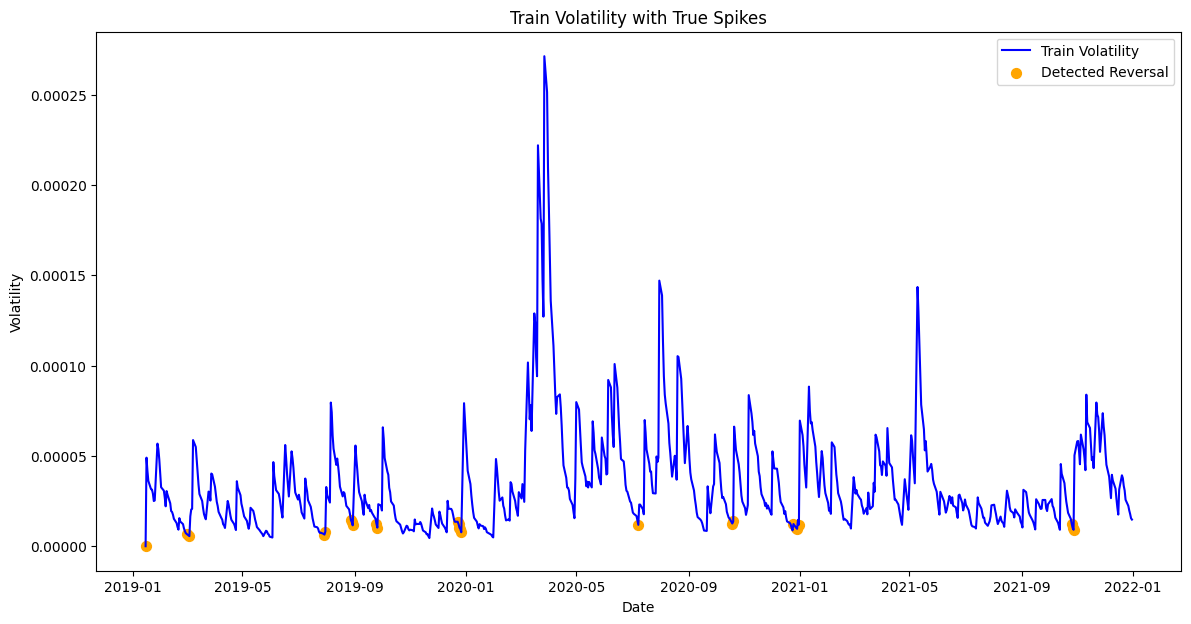

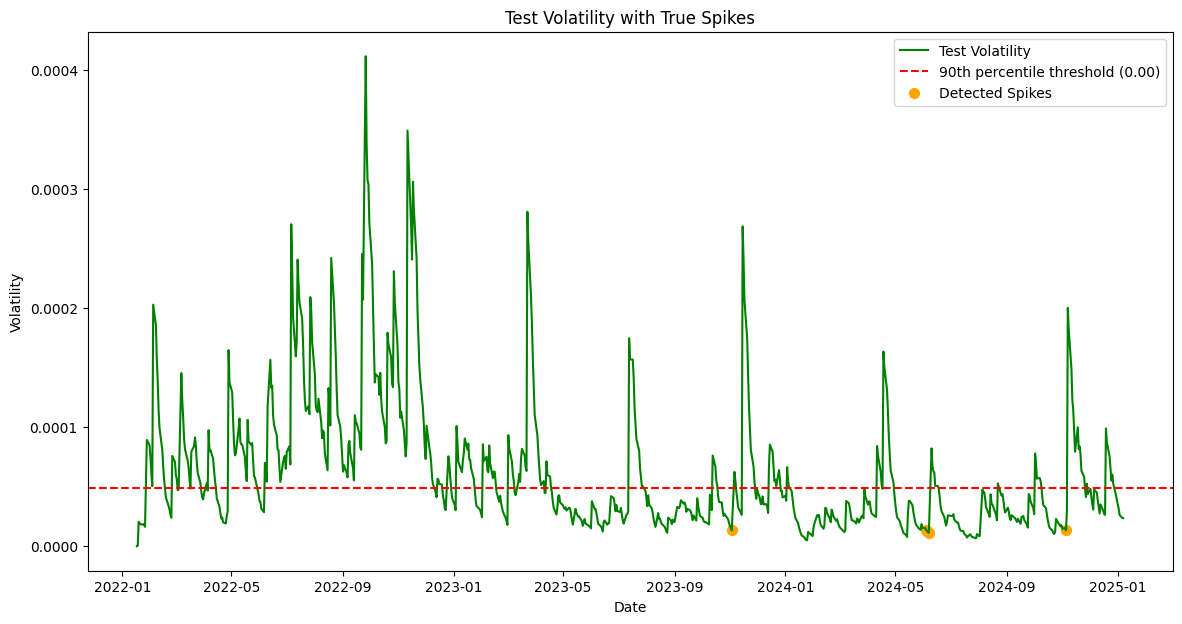

XGBoostError: [01:00:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x79dc12c5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x55b91e) [0x79dc12f5b91e]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x54976d) [0x79dc12f4976d]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x54b99c) [0x79dc12f4b99c]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4fb3ea) [0x79dc12efb3ea]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x18c) [0x79dc12b73a5c]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x79dd54fa6e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x79dd54fa3493]
  [bt] (8) /usr/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0xa4d8) [0x79dd54fb64d8]



In [ ]:
#predict reversal
from imblearn.over_sampling import SMOTE

# Define thresholds
low_threshold = np.quantile(train_volatility['volatility'], 0.20)
high_threshold = np.quantile(train_volatility['volatility'], 0.80)

# Create labels for reversals
def create_reversal_labels(volatility, low_threshold, high_threshold, window=5):
    labels = np.zeros(len(volatility), dtype=int)
    for i in range(len(volatility) - window):
        if volatility[i] < low_threshold and any(volatility[i+1:i+window+1] > high_threshold):
            labels[i] = 1
    return pd.Series(labels, index=volatility.index)

# Create labels
train_label = create_reversal_labels(train_volatility['volatility'], low_threshold, high_threshold)
test_label = create_reversal_labels(test_volatility['volatility'], low_threshold, high_threshold)


#visualize
plt.figure(figsize=(14, 7))
plt.plot(train_volatility.index, train_volatility['volatility'], label="Train Volatility", color='blue')
# plt.axhline(y=spike_threshold, color='red', linestyle='--', label=f"90th percentile threshold ({spike_threshold:.2f})")
plt.scatter(train_volatility.index[train_label == 1], train_volatility['volatility'][train_label == 1], color='orange', s=50, label="Detected Reversal")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Train Volatility with True Spikes")
plt.legend()
plt.show()

# Plot the results for test
plt.figure(figsize=(14, 7))
plt.plot(test_volatility.index, test_volatility['volatility'], label="Test Volatility", color='green')
plt.axhline(y=spike_threshold, color='red', linestyle='--', label=f"90th percentile threshold ({spike_threshold:.2f})")
plt.scatter(test_volatility.index[test_label == 1], test_volatility['volatility'][test_label == 1],
            color='orange', s=50, label="Detected Spikes")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Test Volatility with True Spikes")
plt.legend()
plt.show()

def create_reversal_features(volatility, lags=7):
    df = pd.DataFrame({'volatility': volatility})

    # Lagged features
    for lag in range(1, lags+1):
        df[f'volatility_lag_{lag}'] = df['volatility'].shift(lag)

    # Rolling statistics
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df['volatility'].rolling(window).mean().shift(1)
        df[f'rolling_std_{window}'] = df['volatility'].rolling(window).std().shift(1)
        df[f'vol_zscore_{window}'] = (df['volatility_lag_1'] - df[f'rolling_mean_{window}']) / df[f'rolling_std_{window}']

    # Volatility changes and trends
    df['volatility_change'] = df['volatility_lag_1'] - df['volatility_lag_2']
    df['volatility_acceleration'] = df['volatility_change'] - df['volatility_lag_1'].diff().shift(1)

    # Add volatility ratio
    X_train_reversal['vol_ratio'] = X_train_reversal['volatility_lag_1'] / X_train_reversal['rolling_mean_5']
    X_test_reversal['vol_ratio'] = X_test_reversal['volatility_lag_1'] / X_test_reversal['rolling_mean_5']

    # Add trend indicator
    X_train_reversal['vol_trend'] = X_train_reversal['volatility_lag_1'] - X_train_reversal['volatility_lag_5']
    X_test_reversal['vol_trend'] = X_test_reversal['volatility_lag_1'] - X_test_reversal['volatility_lag_5']

    # Drop NaNs
    df = df.fillna(method='ffill').fillna(0).replace([np.inf, -np.inf], 0)


    return df

# Create feature matrices
X_train_reversal = create_reversal_features(train_volatility['volatility'])
X_test_reversal = create_reversal_features(test_volatility['volatility'])


from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Train XGBoost
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train_reversal, train_label)

scale_pos_weight = len(train_label[train_label == 0]) / len(train_label[train_label == 1])
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight  # Adjust this value if needed
)

# Fit the model
model.fit(X_train_reversal, train_label)
# model.fit(X_train_res, y_train_res)

# Predict on test set
y_test_pred_reversal = model.predict(X_test_reversal)

# Evaluate
print("Test Classification Report:")
print(classification_report(test_label, y_test_pred_reversal))


# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_volatility.index, test_volatility['volatility'], label='Volatility', alpha=0.7)
plt.scatter(test_volatility.index[y_test_pred_reversal == 1], test_volatility['volatility'][y_test_pred_reversal == 1],
            color='red', marker='x', label='Predicted Reversal')
plt.axhline(y=low_threshold, color='gray', linestyle='--', label='Low Volatility Threshold')
plt.axhline(y=high_threshold, color='gray', linestyle='--', label='High Volatility Threshold')
plt.title('Volatility Reversals (Predicted vs Actual)')
plt.legend()
plt.show()

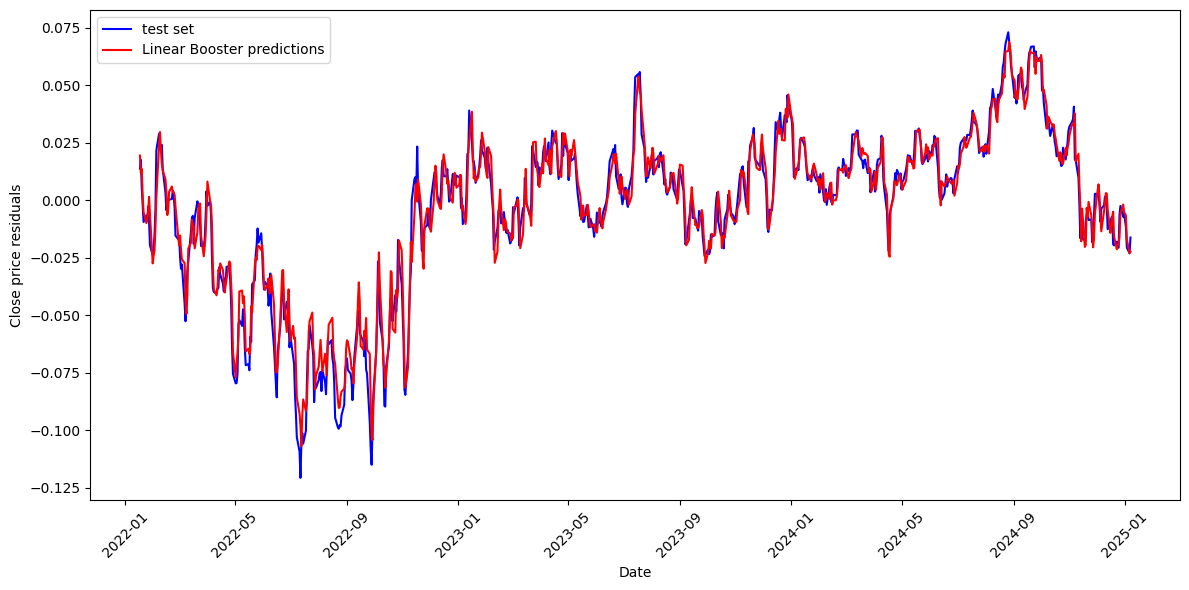

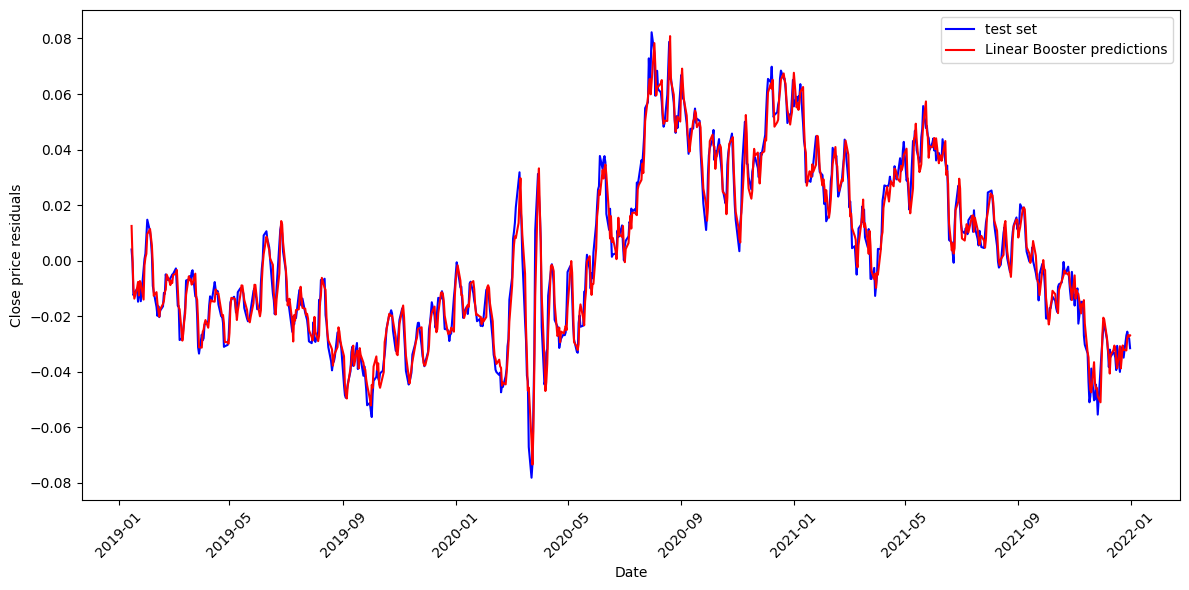

In [ ]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)

name = 'eur_usd'
train_data[name] = val_residuals[name]
train_data[name].index = pd.to_datetime(val_residuals[name].index)

test_data[name] = test_residuals[name]
test_data[name].index = pd.to_datetime(test_residuals[name].index)


#scale data
scaler = RobustScaler()
scaled_train_data= pd.DataFrame(scaler.fit_transform(train_data[name].values.reshape(-1, 1)), index=train_data[name].index)
scaled_test_data= pd.DataFrame(scaler.transform(test_data[name].values.reshape(-1, 1)), index=test_data[name].index)

X_train, y_train = sliding_windows(scaled_train_data, 10)
X_test, y_test = sliding_windows(scaled_test_data, 10)


#flatten
X_test = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.reshape(X_train.shape[0], -1)

#predicct test residuals
test_residuals_prediction = Linear_booster_model[name].predict(X_test) #pre trained model
train_residual_prediction = Linear_booster_model[name].predict(X_train) #pre trained model


#inverse scale
test_prediction = scaler.inverse_transform(test_residuals_prediction.reshape(-1, 1))
train_prediction = scaler.inverse_transform(train_residual_prediction.reshape(-1, 1))


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x = test_data[name][10:].index, y = test_data[name][10:].squeeze(), label = "test set", color = "blue")
sns.lineplot(x = test_data[name][10:].index, y = test_prediction.squeeze(),label = "Linear Booster predictions", color = "red")
plt.ylabel('Close price residuals')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x = train_data[name][10:].index, y = train_data[name][10:].squeeze(), label = "test set", color = "blue")
sns.lineplot(x = train_data[name][10:].index, y = train_prediction.squeeze(),label = "Linear Booster predictions", color = "red")
plt.ylabel('Close price residuals')
plt.xlabel('Date')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

                   error  prediction  error_lag1  error_lag2  error_lag3  \
2019-01-15  7.169122e-05    0.012506    0.000000    0.000000    0.000000   
2019-01-16  2.357980e-06    0.000926    0.000072    0.000000    0.000000   
2019-01-17  5.836261e-06   -0.009997    0.000002    0.000072    0.000000   
2019-01-18  3.693951e-06   -0.013661    0.000006    0.000002    0.000072   
2019-01-21  1.183581e-07   -0.009743    0.000004    0.000006    0.000002   

            prediction_lag1  prediction_lag2  prediction_roll_mean_3  \
2019-01-15         0.000000         0.000000                0.012506   
2019-01-16         0.012506         0.000000                0.006716   
2019-01-17         0.000926         0.012506                0.001145   
2019-01-18        -0.009997         0.000926               -0.007577   
2019-01-21        -0.013661        -0.009997               -0.011133   

            prediction_roll_std_3  prediction_roll_mean_7  \
2019-01-15               0.000000                

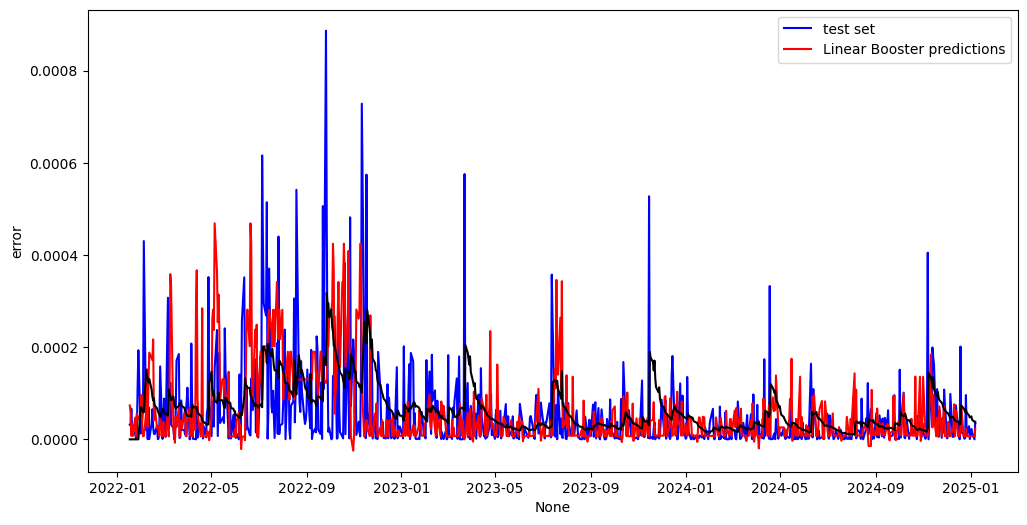

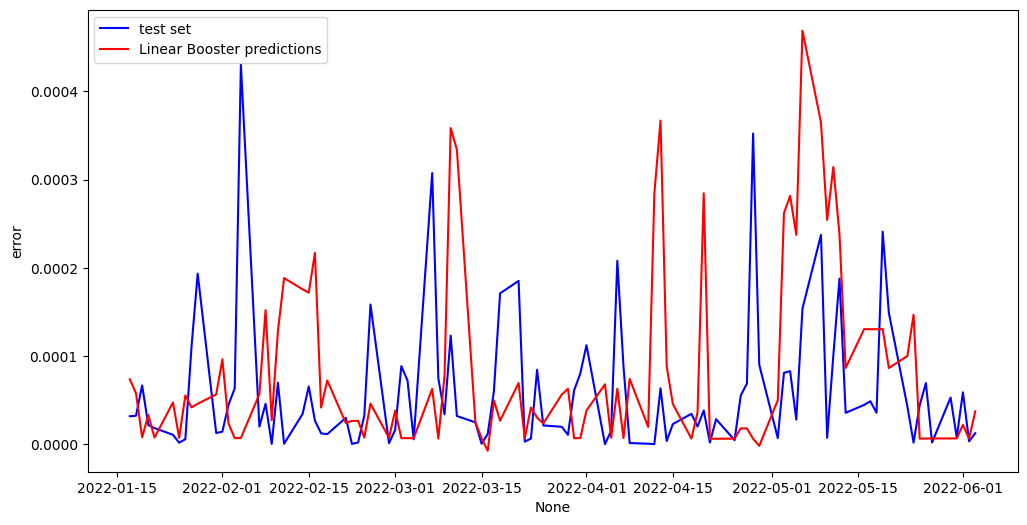

R2: -0.43515786317412664


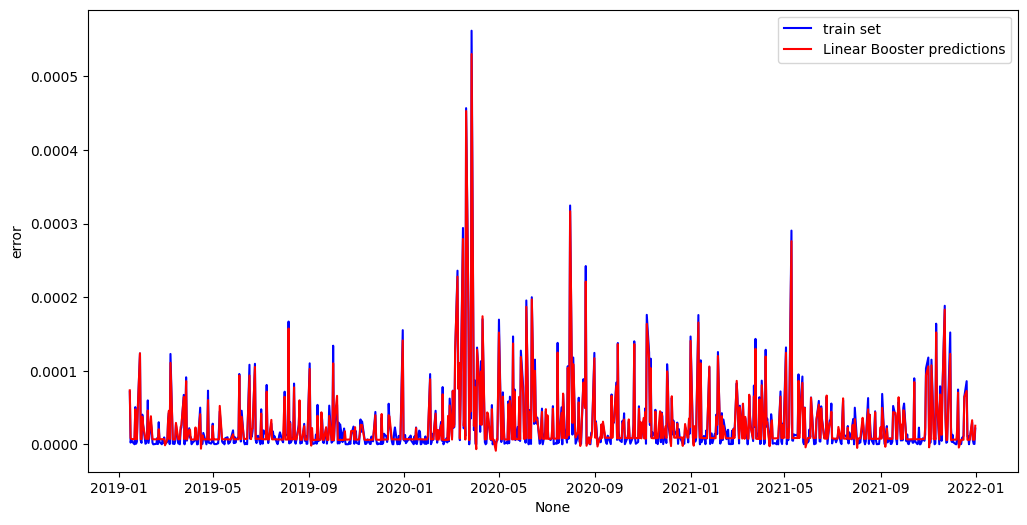

R2: 0.9796016978772216


In [226]:
def feature_engineer(dataset, is_train = False):
    #predicted residuals
    if is_train == True:
        dataset['prediction'] = train_prediction
        # dataset['predicted volatility'] = train_errors['error'].shift(1).ewm(span=5, adjust=False).std().fillna(0)
        # dataset['predicted volatility'] = train_errors['error'].ewm(span=5, adjust=False).std().fillna(0)

    else :
        dataset['prediction'] = test_prediction
        # dataset['predicted volatility'] = test_errors['error'].shift(1).ewm(span=5, adjust=False).std().fillna(0)
        # dataset['predicted volatility'] = test_errors['error'].ewm(span=5, adjust=False).std().fillna(0)



    #lagged features
    for lag in range(1, 4):
        dataset[f'error_lag{lag}'] = dataset['error'].shift(lag)
    for lag in range(1, 3):
        dataset[f'prediction_lag{lag}'] = dataset['prediction'].shift(lag)
        # dataset[f'volatility_lag{lag}'] = dataset['predicted volatility'].shift(lag)


    # # dataset["prediction_lag1"] = dataset["prediction"].shift(1)
    # # dataset["prediction_lag2"] = dataset["prediction"].shift(2)
    # # dataset["prediction_lag3"] = dataset["prediction"].shift(3)

    #rolling features
    for window in [3, 7, 14]:
        dataset[f'prediction_roll_mean_{window}'] = dataset['prediction'].rolling(window=window, min_periods=1).mean()
        dataset[f'prediction_roll_std_{window}']  = dataset['prediction'].rolling(window=window, min_periods=1).std()
        # dataset[f'prediction_roll_max_{window}']  = dataset['prediction'].rolling(window=window, min_periods=1).max()
        # dataset[f'preiction_roll_min_{window}']  = dataset['prediction'].rolling(window=window, min_periods=1).min()

    # New features
    # Moving statistics
    # dataset['error_ma_3'] = dataset['error'].rolling(3).mean().fillna(0)
    # dataset['error_ema_5'] = dataset['error'].ewm(span=5, adjust=False).mean().fillna(0)

    # #visualize
    # plt.figure(figsize=(12, 6))
    # sns.lineplot(x = dataset['error'].index, y = dataset['error'].squeeze(), label = "error", color = "blue")
    # sns.lineplot(x = dataset.index, y = dataset['error_ma_3'].squeeze(),label = "error_ma_3", color = "red")
    # sns.lineplot(x = dataset.index, y = dataset['error_ema_5'].squeeze(),label = "error_ema_5", color = "green")
    # plt.show()

    # Interaction features
    for lag in range(1, 3):
        dataset[f'error_pred_interaction_lag{lag}'] = dataset[f'error_lag{lag}'] * dataset[f'prediction_lag{lag}']

    # Non-linear transforms
    # for lag in range(1, 2):
    #     dataset[f'error_lag{lag}_squared'] = dataset[f'error_lag{lag}'] ** 2

    # Temporal dynamics
    # dataset['error_volatility'] = dataset['error'].ewm(span=10, adjust=False).std().fillna(0)
    dataset['error_volatility'] = predicted_test_volatility.iloc[:,0]
    dataset['error_volatility_lag1'] = dataset['error_volatility'].shift(1).fillna(0)

    # Differencing
    # dataset['error_delta_1'] = dataset['error'].shift(1).diff(1).fillna(0)


    # # for window in [3, 7, 14]:
    # # for window in [3, 7, 14]:
    # #     dataset[f'error_roll_mean_{window}'] = dataset['error'].rolling(window=window, min_periods=1).mean().shift(1)

    # #momentum of predictions
    # dataset["prediction_diff1"] = dataset["prediction_lag1"] - dataset["prediction_lag2"]

    #acceleration of predictions (second difference)
    # dataset["prediction_diff2"] = dataset["prediction_diff1"] - dataset["prediction_diff1"].shift(1)

    #interaction features
    # dataset['prediction_volatility_interaction'] = dataset['prediction'] * dataset['predicted volatility']

    # # New Feature 1: First difference of error (error momentum)
    # dataset['error_diff1'] = dataset['error_lag1'] - dataset['error_lag2']

    # # New Feature 2: Second difference of error (error acceleration)
    # dataset['error_diff2'] = dataset['error_diff1'] - dataset['error_diff1'].shift(1)

    # # New Feature 3: Z-score normalization of error using the 7-period rolling statistics
    # dataset['error_zscore_7'] = (dataset['error_lag1'] - dataset['error_roll_mean_7']) / dataset['error_roll_std_7']

    # # New Feature 4: Exponential weighted moving average (EWMA) of error
    # dataset['error_ewma_7'] = dataset['error_lag1'].ewm(span=7, adjust=False).mean()

    # # New Feature 5: Interaction feature between predicted residuals and lagged error
    # dataset['predicted_x_error_lag1'] = dataset['prediction'] * dataset['error_lag1']




    # # Momentum of predictions (first difference)
    # dataset["prediction_diff1"] = dataset["prediction_lag1"] - dataset["prediction_lag2"]

    # # Acceleration of predictions (second difference)
    # dataset["prediction_diff2"] = dataset["prediction_diff1"] - dataset["prediction_diff1"].shift(1)

    # # Z-score normalization of predictions
    # dataset["prediction_zscore_7"] = (
    #     (dataset["prediction_lag1"] - dataset["prediction_rolling_mean_7"])
    #     / dataset["prediction_rolling_std_7"]
    # )

    # # Exponential weighted moving average (EWMA) of predictions
    # dataset["prediction_ewma_7"] = dataset["prediction_lag1"].ewm(span=7, adjust=False).mean()

    # # Time-based features (if index is datetime)
    # dataset["day_of_week"] = dataset.index.dayofweek
    # dataset["month"] = dataset.index.month

    # # Interaction features
    # dataset["prediction_x_lag1"] = dataset["prediction"] * dataset["prediction_lag1"]

    # New Feature 6: Time-based features (if your index is a datetime)
    # dataset['day_of_week'] = dataset.index.dayofweek
    # dataset['month'] = dataset.index.month




#get errors
train_errors = pd.read_csv("train_errori.csv", index_col=0, names=["error"], header=0)
test_errors = pd.read_csv("test_errori.csv", index_col=0, names=["error"], header=0)

test_errors.index = pd.to_datetime(test_errors.index)
train_errors.index = pd.to_datetime(train_errors.index)

feature_engineer(train_errors, True)
feature_engineer(test_errors)

#nan to 0
train_errors = train_errors.fillna(0)
test_errors = test_errors.fillna(0)



print(train_errors.head())
print(test_errors.head())
# train_errors.index = pd.to_datetime(train_errors.index)
# test_errors.index = pd.to_datetime(test_errors.index)

X_train = train_errors.drop('error', axis=1)
y_train = train_errors['error']

X_test = test_errors.drop('error', axis=1)
y_test = test_errors['error']


#train model
best_params = {"n_estimators": 150,  "max_depth": 15,  "min_samples_split" : 10, "min_samples_leaf" : 0.003}
ridge = Ridge(alpha=0.5)


model = LinearBoostRegressor(base_estimator=ridge, **best_params)
model.fit(X_train, y_train)


#predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x = test_errors['error'].index, y = test_errors['error'].squeeze(), label = "test set", color = "blue")
sns.lineplot(x = test_errors.index, y = y_test_pred,label = "Linear Booster predictions", color = "red")
sns.lineplot(x = test_errors.index  , y = test_errors['error_volatility'].squeeze(), color = 'black')
plt.show()

#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x = test_errors['error'][:100].index, y = test_errors['error'][:100].squeeze(), label = "test set", color = "blue")
sns.lineplot(x = test_errors[:100].index, y = y_test_pred[:100] ,label = "Linear Booster predictions", color = "red")
plt.show()

#metrics
r2 = r2_score(test_errors['error'], y_test_pred)
print(f"R2: {r2}")

#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x = train_errors['error'].index, y = train_errors['error'].squeeze(), label = "train set", color = "blue")
sns.lineplot(x = train_errors.index, y = y_train_pred,label = "Linear Booster predictions", color = "red")
plt.show()


#metrics
r2 = r2_score(train_errors['error'], y_train_pred)
print(f"R2: {r2}")